In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path
from skimage.exposure import match_histograms

from utils import segment_contour

In [2]:
def aspect_ratio(contour):
    x,y,w,h = cv2.boundingRect(contour)
    ar = float(w)/h
    return ar


In [3]:

reference = cv2.imread('../2_live_bees/reference_card_2024_06_06_h05bee62.png')
fps = glob('../2_live_bees/1_cards/*')
np.random.shuffle(fps)

In [250]:
DEBUG = False

no_contours_found = []

for fp in tqdm(fps):
    if DEBUG:
        fp = '../2_live_bees/1_cards/2024_06_17_h04b13.png'
    
    fp = Path(fp)
    fn = fp.name
    
    contours = []
    threshold = 150
    card = cv2.imread(fp)
    matched = match_histograms(card, reference, channel_axis=-1)
    blurred = cv2.blur(matched, (25,25))

    i = 0
    while (len(contours) == 0) and (i < 8):    matched = match_histograms(card, reference, channel_axis=-1)
        threshold += 10
        i += 1
        thres = (cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < threshold).astype('uint8')
        if DEBUG:
            plt.figure()
            plt.imshow(thres)
            plt.title('Thresholded Image')
    
        contours,hierarchy = cv2.findContours(thres, 1, 2)
        
        contours = [x  for x in contours if cv2.contourArea(x) > 10000]
        contours = [x  for x in contours if cv2.contourArea(x) < 50000]
        contours = [x  for x in contours if aspect_ratio(x) < 0.15]
        contours = [x  for x in contours if aspect_ratio(x) > 0.07]

        
    if len(contours) != 1:
        if len(contours) > 1:
            # annoyingly complicated way to sort the contours by their aspect ratio
            contours = list(map(contours.__getitem__, np.argsort([aspect_ratio(x) for x in contours])))
            contours = [contours[0]]
            for i in range(len(contours)):
                contour = contours[i]
                mask = np.zeros(thres.shape)
                mask = cv2.drawContours(mask, [contour], -1, (1,1,1), -1)
                if DEBUG:
                    plt.figure()
                    plt.imshow(mask.astype('uint8'))
                    plt.title(str(i) + ', ' + str(cv2.contourArea(contour)) + ', ' + str(aspect_ratio(contour)))
        else:
            thres = (cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 160).astype('uint8')

            no_contours_found += [fp]
            print('No contours found', fp)
            prob = np.zeros((card.shape[0], card.shape[1]*2, 3))
            prob[:,:card.shape[1],0] = thres*255
            prob[:,card.shape[1]:] = card
            problem_fp = '../2_live_bees/5_cannot_find_line/' + fn
            cv2.imwrite(problem_fp, prob)
            continue

    seg, mask = segment_contour(card, contours[0])

    seg_and_orig = np.zeros((card.shape[0], card.shape[1]*2, 3))
    seg_and_orig[:,:card.shape[1]] = seg
    seg_and_orig[:,card.shape[1]:] = card
    
    seg_fp = '../2_live_bees/5_line_segs/' + fn
    mask_fp = '../2_live_bees/5_line_masks/' + fn
    seg_and_orig_fp = '../2_live_bees/5_seg_and_orig/' + fn
    cv2.imwrite(seg_fp, seg)
    cv2.imwrite(mask_fp, mask)
    cv2.imwrite(seg_and_orig_fp, seg_and_orig)

    x,y,w,h = cv2.boundingRect(contours[0])
    metadata = {
        'x':x,
        'y':y,
        'width':w,
        'height':h,
        'size':cv2.contourArea(contours[0]),
        'aspect_ratio':aspect_ratio(contours[0]),
        'pixels_per_cm': h / 0.5,
    }
    print(h / 0.5)
    metadata_fp = '../2_live_bees/5_size_metadata/' + fn.replace('.png','.json')
    with open(metadata_fp, 'w') as f:
        json.dump(metadata, f)
    
    if DEBUG:
        break
    
print(len(contours))

  0%|▏                                                                                                                                                                      | 1/1193 [00:00<19:39,  1.01it/s]

1184.0


  0%|▎                                                                                                                                                                      | 2/1193 [00:02<20:52,  1.05s/it]

1232.0


  0%|▍                                                                                                                                                                      | 3/1193 [00:03<19:56,  1.01s/it]

1218.0


  0%|▌                                                                                                                                                                      | 4/1193 [00:04<19:44,  1.00it/s]

1232.0


  0%|▋                                                                                                                                                                      | 5/1193 [00:05<19:57,  1.01s/it]

1252.0
No contours found ../2_live_bees/1_cards/2024_06_05_h01bee23.png


  1%|▉                                                                                                                                                                      | 7/1193 [00:06<19:14,  1.03it/s]

1258.0


  1%|█                                                                                                                                                                      | 8/1193 [00:07<19:35,  1.01it/s]

1330.0


  1%|█▎                                                                                                                                                                     | 9/1193 [00:08<18:53,  1.04it/s]

1180.0


  1%|█▍                                                                                                                                                                    | 10/1193 [00:09<18:53,  1.04it/s]

1244.0


  1%|█▌                                                                                                                                                                    | 11/1193 [00:10<19:10,  1.03it/s]

1224.0


  1%|█▋                                                                                                                                                                    | 12/1193 [00:11<18:52,  1.04it/s]

1212.0


  1%|█▊                                                                                                                                                                    | 13/1193 [00:12<20:34,  1.05s/it]

1258.0


  1%|█▉                                                                                                                                                                    | 14/1193 [00:13<20:09,  1.03s/it]

1222.0


  1%|██                                                                                                                                                                    | 15/1193 [00:14<19:46,  1.01s/it]

1202.0


  1%|██▏                                                                                                                                                                   | 16/1193 [00:15<19:17,  1.02it/s]

1210.0


  1%|██▎                                                                                                                                                                   | 17/1193 [00:16<18:55,  1.04it/s]

806.0


  2%|██▌                                                                                                                                                                   | 18/1193 [00:17<18:49,  1.04it/s]

1238.0


  2%|██▋                                                                                                                                                                   | 19/1193 [00:18<19:02,  1.03it/s]

1072.0


  2%|██▊                                                                                                                                                                   | 20/1193 [00:19<18:19,  1.07it/s]

1206.0


  2%|██▉                                                                                                                                                                   | 21/1193 [00:20<18:11,  1.07it/s]

1184.0


  2%|███                                                                                                                                                                   | 22/1193 [00:21<18:11,  1.07it/s]

1194.0


  2%|███▏                                                                                                                                                                  | 23/1193 [00:22<18:15,  1.07it/s]

1266.0


  2%|███▎                                                                                                                                                                  | 24/1193 [00:23<18:30,  1.05it/s]

1206.0


  2%|███▍                                                                                                                                                                  | 25/1193 [00:24<18:42,  1.04it/s]

1228.0


  2%|███▌                                                                                                                                                                  | 26/1193 [00:25<19:02,  1.02it/s]

1192.0


  2%|███▊                                                                                                                                                                  | 27/1193 [00:26<18:25,  1.05it/s]

1356.0


  2%|███▉                                                                                                                                                                  | 28/1193 [00:27<18:42,  1.04it/s]

1254.0


  2%|████                                                                                                                                                                  | 29/1193 [00:28<18:47,  1.03it/s]

1144.0


  3%|████▏                                                                                                                                                                 | 30/1193 [00:29<18:21,  1.06it/s]

1242.0
No contours found ../2_live_bees/1_cards/2024_06_18_h11b13.png


  3%|████▍                                                                                                                                                                 | 32/1193 [00:30<17:33,  1.10it/s]

1224.0


  3%|████▌                                                                                                                                                                 | 33/1193 [00:31<17:10,  1.13it/s]

1380.0


  3%|████▋                                                                                                                                                                 | 34/1193 [00:32<17:12,  1.12it/s]

1098.0


  3%|████▊                                                                                                                                                                 | 35/1193 [00:33<18:12,  1.06it/s]

1298.0


  3%|█████                                                                                                                                                                 | 36/1193 [00:34<18:55,  1.02it/s]

1354.0


  3%|█████▏                                                                                                                                                                | 37/1193 [00:35<19:15,  1.00it/s]

1240.0


  3%|█████▎                                                                                                                                                                | 38/1193 [00:36<19:18,  1.00s/it]

1214.0


  3%|█████▍                                                                                                                                                                | 39/1193 [00:37<19:13,  1.00it/s]

1218.0


  3%|█████▌                                                                                                                                                                | 40/1193 [00:38<18:51,  1.02it/s]

1186.0


  3%|█████▋                                                                                                                                                                | 41/1193 [00:39<19:15,  1.00s/it]

1302.0


  4%|█████▊                                                                                                                                                                | 42/1193 [00:40<19:10,  1.00it/s]

1218.0


  4%|█████▉                                                                                                                                                                | 43/1193 [00:41<19:26,  1.01s/it]

1252.0


  4%|██████                                                                                                                                                                | 44/1193 [00:42<19:25,  1.01s/it]

1294.0


  4%|██████▎                                                                                                                                                               | 45/1193 [00:43<18:52,  1.01it/s]

1108.0


  4%|██████▍                                                                                                                                                               | 46/1193 [00:44<18:34,  1.03it/s]

1204.0


  4%|██████▌                                                                                                                                                               | 47/1193 [00:45<18:24,  1.04it/s]

1298.0


  4%|██████▋                                                                                                                                                               | 48/1193 [00:46<18:07,  1.05it/s]

1220.0


  4%|██████▊                                                                                                                                                               | 49/1193 [00:47<17:18,  1.10it/s]

1316.0


  4%|██████▉                                                                                                                                                               | 50/1193 [00:48<17:14,  1.10it/s]

1228.0


  4%|███████                                                                                                                                                               | 51/1193 [00:49<17:38,  1.08it/s]

1128.0


  4%|███████▏                                                                                                                                                              | 52/1193 [00:50<18:10,  1.05it/s]

1208.0


  4%|███████▎                                                                                                                                                              | 53/1193 [00:51<17:57,  1.06it/s]

1166.0


  5%|███████▌                                                                                                                                                              | 54/1193 [00:52<17:49,  1.06it/s]

1166.0


  5%|███████▋                                                                                                                                                              | 55/1193 [00:53<19:17,  1.02s/it]

1098.0


  5%|███████▊                                                                                                                                                              | 56/1193 [00:54<18:57,  1.00s/it]

1214.0


  5%|███████▉                                                                                                                                                              | 57/1193 [00:55<18:30,  1.02it/s]

1258.0


  5%|████████                                                                                                                                                              | 58/1193 [00:56<18:32,  1.02it/s]

1284.0


  5%|████████▏                                                                                                                                                             | 59/1193 [00:57<18:04,  1.05it/s]

1284.0


  5%|████████▎                                                                                                                                                             | 60/1193 [00:57<17:27,  1.08it/s]

1234.0


  5%|████████▍                                                                                                                                                             | 61/1193 [00:58<17:29,  1.08it/s]

1262.0


  5%|████████▋                                                                                                                                                             | 62/1193 [00:59<17:54,  1.05it/s]

1252.0


  5%|████████▊                                                                                                                                                             | 63/1193 [01:00<18:12,  1.03it/s]

1246.0


  5%|████████▉                                                                                                                                                             | 64/1193 [01:01<18:20,  1.03it/s]

1226.0


  5%|█████████                                                                                                                                                             | 65/1193 [01:02<18:28,  1.02it/s]

1208.0


  6%|█████████▏                                                                                                                                                            | 66/1193 [01:03<19:00,  1.01s/it]

1140.0


  6%|█████████▎                                                                                                                                                            | 67/1193 [01:04<19:07,  1.02s/it]

1246.0


  6%|█████████▍                                                                                                                                                            | 68/1193 [01:05<18:25,  1.02it/s]

1224.0


  6%|█████████▌                                                                                                                                                            | 69/1193 [01:06<18:19,  1.02it/s]

1250.0


  6%|█████████▋                                                                                                                                                            | 70/1193 [01:07<18:26,  1.02it/s]

1198.0


  6%|█████████▉                                                                                                                                                            | 71/1193 [01:08<18:18,  1.02it/s]

1222.0


  6%|██████████                                                                                                                                                            | 72/1193 [01:09<18:02,  1.04it/s]

1258.0


  6%|██████████▏                                                                                                                                                           | 73/1193 [01:10<18:43,  1.00s/it]

1242.0


  6%|██████████▎                                                                                                                                                           | 74/1193 [01:11<17:52,  1.04it/s]

1334.0
No contours found ../2_live_bees/1_cards/2024_06_05_h01bee19.png


  6%|██████████▌                                                                                                                                                           | 76/1193 [01:13<17:34,  1.06it/s]

1150.0
No contours found ../2_live_bees/1_cards/2024_06_18_h11b11.png


  7%|██████████▊                                                                                                                                                           | 78/1193 [01:15<17:44,  1.05it/s]

1308.0


  7%|██████████▉                                                                                                                                                           | 79/1193 [01:16<18:01,  1.03it/s]

1316.0


  7%|███████████▏                                                                                                                                                          | 80/1193 [01:17<18:08,  1.02it/s]

1262.0


  7%|███████████▎                                                                                                                                                          | 81/1193 [01:18<18:15,  1.01it/s]

1230.0


  7%|███████████▍                                                                                                                                                          | 82/1193 [01:19<18:53,  1.02s/it]

1262.0


  7%|███████████▌                                                                                                                                                          | 83/1193 [01:20<18:20,  1.01it/s]

1268.0


  7%|███████████▋                                                                                                                                                          | 84/1193 [01:21<18:18,  1.01it/s]

1208.0


  7%|███████████▊                                                                                                                                                          | 85/1193 [01:22<18:46,  1.02s/it]

1228.0


  7%|███████████▉                                                                                                                                                          | 86/1193 [01:23<18:44,  1.02s/it]

1230.0


  7%|████████████                                                                                                                                                          | 87/1193 [01:24<19:09,  1.04s/it]

1164.0


  7%|████████████▏                                                                                                                                                         | 88/1193 [01:25<19:17,  1.05s/it]

1322.0


  7%|████████████▍                                                                                                                                                         | 89/1193 [01:26<18:52,  1.03s/it]

1144.0


  8%|████████████▌                                                                                                                                                         | 90/1193 [01:27<18:01,  1.02it/s]

1270.0


  8%|████████████▋                                                                                                                                                         | 91/1193 [01:28<17:41,  1.04it/s]

1272.0


  8%|████████████▊                                                                                                                                                         | 92/1193 [01:29<17:46,  1.03it/s]

1206.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b41.png


  8%|█████████████                                                                                                                                                         | 94/1193 [01:31<17:44,  1.03it/s]

1230.0


  8%|█████████████▏                                                                                                                                                        | 95/1193 [01:32<17:44,  1.03it/s]

1350.0


  8%|█████████████▎                                                                                                                                                        | 96/1193 [01:33<17:58,  1.02it/s]

1070.0


  8%|█████████████▍                                                                                                                                                        | 97/1193 [01:34<17:59,  1.02it/s]

1262.0


  8%|█████████████▋                                                                                                                                                        | 98/1193 [01:35<18:17,  1.00s/it]

1294.0


  8%|█████████████▊                                                                                                                                                        | 99/1193 [01:36<18:05,  1.01it/s]

1238.0


  8%|█████████████▊                                                                                                                                                       | 100/1193 [01:37<18:09,  1.00it/s]

1206.0


  8%|█████████████▉                                                                                                                                                       | 101/1193 [01:38<17:58,  1.01it/s]

1220.0


  9%|██████████████                                                                                                                                                       | 102/1193 [01:39<18:08,  1.00it/s]

1210.0


  9%|██████████████▏                                                                                                                                                      | 103/1193 [01:40<18:19,  1.01s/it]

1234.0


  9%|██████████████▍                                                                                                                                                      | 104/1193 [01:41<18:07,  1.00it/s]

1212.0


  9%|██████████████▌                                                                                                                                                      | 105/1193 [01:42<18:14,  1.01s/it]

1172.0


  9%|██████████████▋                                                                                                                                                      | 106/1193 [01:43<18:06,  1.00it/s]

1226.0


  9%|██████████████▊                                                                                                                                                      | 107/1193 [01:44<18:01,  1.00it/s]

1264.0


  9%|██████████████▉                                                                                                                                                      | 108/1193 [01:45<17:07,  1.06it/s]

1346.0


  9%|███████████████                                                                                                                                                      | 109/1193 [01:46<17:16,  1.05it/s]

1172.0


  9%|███████████████▏                                                                                                                                                     | 110/1193 [01:47<17:26,  1.03it/s]

1240.0


  9%|███████████████▎                                                                                                                                                     | 111/1193 [01:48<17:59,  1.00it/s]

1288.0


  9%|███████████████▍                                                                                                                                                     | 112/1193 [01:48<17:09,  1.05it/s]

1140.0


  9%|███████████████▋                                                                                                                                                     | 113/1193 [01:49<17:26,  1.03it/s]

1004.0


 10%|███████████████▊                                                                                                                                                     | 114/1193 [01:50<17:28,  1.03it/s]

1162.0


 10%|███████████████▉                                                                                                                                                     | 115/1193 [01:52<18:00,  1.00s/it]

1314.0


 10%|████████████████                                                                                                                                                     | 116/1193 [01:53<18:06,  1.01s/it]

940.0


 10%|████████████████▏                                                                                                                                                    | 117/1193 [01:54<17:47,  1.01it/s]

1192.0


 10%|████████████████▎                                                                                                                                                    | 118/1193 [01:55<17:47,  1.01it/s]

1210.0


 10%|████████████████▍                                                                                                                                                    | 119/1193 [01:56<18:35,  1.04s/it]

980.0


 10%|████████████████▌                                                                                                                                                    | 120/1193 [01:57<18:31,  1.04s/it]

1296.0


 10%|████████████████▋                                                                                                                                                    | 121/1193 [01:58<17:56,  1.00s/it]

1196.0


 10%|████████████████▊                                                                                                                                                    | 122/1193 [01:59<17:22,  1.03it/s]

1262.0


 10%|█████████████████                                                                                                                                                    | 123/1193 [01:59<17:02,  1.05it/s]

1212.0


 10%|█████████████████▏                                                                                                                                                   | 124/1193 [02:00<16:58,  1.05it/s]

1188.0


 10%|█████████████████▎                                                                                                                                                   | 125/1193 [02:01<16:44,  1.06it/s]

1202.0


 11%|█████████████████▍                                                                                                                                                   | 126/1193 [02:02<16:46,  1.06it/s]

1368.0


 11%|█████████████████▌                                                                                                                                                   | 127/1193 [02:03<16:42,  1.06it/s]

1254.0


 11%|█████████████████▋                                                                                                                                                   | 128/1193 [02:04<17:03,  1.04it/s]

1220.0


 11%|█████████████████▊                                                                                                                                                   | 129/1193 [02:05<16:57,  1.05it/s]

1278.0


 11%|█████████████████▉                                                                                                                                                   | 130/1193 [02:06<17:03,  1.04it/s]

1214.0


 11%|██████████████████                                                                                                                                                   | 131/1193 [02:07<16:34,  1.07it/s]

1176.0


 11%|██████████████████▎                                                                                                                                                  | 132/1193 [02:08<16:29,  1.07it/s]

1182.0


 11%|██████████████████▍                                                                                                                                                  | 133/1193 [02:09<16:34,  1.07it/s]

1216.0


 11%|██████████████████▌                                                                                                                                                  | 134/1193 [02:10<16:33,  1.07it/s]

1252.0


 11%|██████████████████▋                                                                                                                                                  | 135/1193 [02:11<16:43,  1.05it/s]

1254.0


 11%|██████████████████▊                                                                                                                                                  | 136/1193 [02:12<16:40,  1.06it/s]

1220.0


 11%|██████████████████▉                                                                                                                                                  | 137/1193 [02:13<16:34,  1.06it/s]

698.0


 12%|███████████████████                                                                                                                                                  | 138/1193 [02:14<16:52,  1.04it/s]

1158.0


 12%|███████████████████▏                                                                                                                                                 | 139/1193 [02:15<16:42,  1.05it/s]

1204.0


 12%|███████████████████▎                                                                                                                                                 | 140/1193 [02:16<16:47,  1.05it/s]

1200.0


 12%|███████████████████▌                                                                                                                                                 | 141/1193 [02:17<17:00,  1.03it/s]

1248.0


 12%|███████████████████▋                                                                                                                                                 | 142/1193 [02:18<17:14,  1.02it/s]

1166.0


 12%|███████████████████▊                                                                                                                                                 | 143/1193 [02:18<16:44,  1.05it/s]

1212.0


 12%|███████████████████▉                                                                                                                                                 | 144/1193 [02:19<16:18,  1.07it/s]

1234.0


 12%|████████████████████                                                                                                                                                 | 145/1193 [02:20<16:31,  1.06it/s]

1230.0


 12%|████████████████████▏                                                                                                                                                | 146/1193 [02:21<16:31,  1.06it/s]

1198.0


 12%|████████████████████▎                                                                                                                                                | 147/1193 [02:22<16:48,  1.04it/s]

1234.0


 12%|████████████████████▍                                                                                                                                                | 148/1193 [02:23<16:34,  1.05it/s]

890.0


 12%|████████████████████▌                                                                                                                                                | 149/1193 [02:24<16:42,  1.04it/s]

1310.0


 13%|████████████████████▋                                                                                                                                                | 150/1193 [02:25<16:48,  1.03it/s]

1306.0


 13%|████████████████████▉                                                                                                                                                | 151/1193 [02:26<16:57,  1.02it/s]

1294.0


 13%|█████████████████████                                                                                                                                                | 152/1193 [02:27<16:37,  1.04it/s]

1206.0


 13%|█████████████████████▏                                                                                                                                               | 153/1193 [02:28<16:39,  1.04it/s]

1226.0


 13%|█████████████████████▎                                                                                                                                               | 154/1193 [02:29<15:58,  1.08it/s]

1268.0


 13%|█████████████████████▍                                                                                                                                               | 155/1193 [02:30<16:00,  1.08it/s]

1246.0


 13%|█████████████████████▌                                                                                                                                               | 156/1193 [02:31<16:25,  1.05it/s]

1226.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b03.png


 13%|█████████████████████▊                                                                                                                                               | 158/1193 [02:33<15:50,  1.09it/s]

1290.0


 13%|█████████████████████▉                                                                                                                                               | 159/1193 [02:34<16:11,  1.06it/s]

1234.0


 13%|██████████████████████▏                                                                                                                                              | 160/1193 [02:35<16:31,  1.04it/s]

1256.0


 13%|██████████████████████▎                                                                                                                                              | 161/1193 [02:35<16:20,  1.05it/s]

1230.0


 14%|██████████████████████▍                                                                                                                                              | 162/1193 [02:37<18:02,  1.05s/it]

1296.0


 14%|██████████████████████▌                                                                                                                                              | 163/1193 [02:38<18:31,  1.08s/it]

1170.0


 14%|██████████████████████▋                                                                                                                                              | 164/1193 [02:39<18:37,  1.09s/it]

1172.0


 14%|██████████████████████▊                                                                                                                                              | 165/1193 [02:40<17:43,  1.03s/it]

1276.0


 14%|██████████████████████▉                                                                                                                                              | 166/1193 [02:41<17:37,  1.03s/it]

1222.0


 14%|███████████████████████                                                                                                                                              | 167/1193 [02:42<16:36,  1.03it/s]

1248.0


 14%|███████████████████████▏                                                                                                                                             | 168/1193 [02:43<16:12,  1.05it/s]

1264.0


 14%|███████████████████████▎                                                                                                                                             | 169/1193 [02:44<16:19,  1.05it/s]

1204.0


 14%|███████████████████████▌                                                                                                                                             | 170/1193 [02:45<15:53,  1.07it/s]

1186.0


 14%|███████████████████████▋                                                                                                                                             | 171/1193 [02:45<16:03,  1.06it/s]

1192.0


 14%|███████████████████████▊                                                                                                                                             | 172/1193 [02:46<16:24,  1.04it/s]

1004.0


 15%|███████████████████████▉                                                                                                                                             | 173/1193 [02:47<16:22,  1.04it/s]

930.0


 15%|████████████████████████                                                                                                                                             | 174/1193 [02:48<16:22,  1.04it/s]

1254.0


 15%|████████████████████████▏                                                                                                                                            | 175/1193 [02:49<16:36,  1.02it/s]

1398.0


 15%|████████████████████████▎                                                                                                                                            | 176/1193 [02:50<16:44,  1.01it/s]

1246.0


 15%|████████████████████████▍                                                                                                                                            | 177/1193 [02:51<15:59,  1.06it/s]

1296.0


 15%|████████████████████████▌                                                                                                                                            | 178/1193 [02:52<16:24,  1.03it/s]

1310.0


 15%|████████████████████████▊                                                                                                                                            | 179/1193 [02:53<16:47,  1.01it/s]

1226.0


 15%|████████████████████████▉                                                                                                                                            | 180/1193 [02:54<16:17,  1.04it/s]

1232.0


 15%|█████████████████████████                                                                                                                                            | 181/1193 [02:55<16:07,  1.05it/s]

1146.0


 15%|█████████████████████████▏                                                                                                                                           | 182/1193 [02:56<15:07,  1.11it/s]

1210.0


 15%|█████████████████████████▎                                                                                                                                           | 183/1193 [02:57<15:21,  1.10it/s]

1232.0


 15%|█████████████████████████▍                                                                                                                                           | 184/1193 [02:58<15:33,  1.08it/s]

996.0


 16%|█████████████████████████▌                                                                                                                                           | 185/1193 [02:59<15:39,  1.07it/s]

1128.0


 16%|█████████████████████████▋                                                                                                                                           | 186/1193 [03:00<15:30,  1.08it/s]

1250.0


 16%|█████████████████████████▊                                                                                                                                           | 187/1193 [03:01<15:58,  1.05it/s]

1190.0


 16%|██████████████████████████                                                                                                                                           | 188/1193 [03:02<16:18,  1.03it/s]

1188.0


 16%|██████████████████████████▏                                                                                                                                          | 189/1193 [03:03<16:24,  1.02it/s]

1310.0


 16%|██████████████████████████▎                                                                                                                                          | 190/1193 [03:04<16:12,  1.03it/s]

1200.0


 16%|██████████████████████████▍                                                                                                                                          | 191/1193 [03:05<16:24,  1.02it/s]

1206.0


 16%|██████████████████████████▌                                                                                                                                          | 192/1193 [03:05<15:24,  1.08it/s]

1336.0


 16%|██████████████████████████▋                                                                                                                                          | 193/1193 [03:07<16:16,  1.02it/s]

1266.0


 16%|██████████████████████████▊                                                                                                                                          | 194/1193 [03:08<16:04,  1.04it/s]

1252.0


 16%|██████████████████████████▉                                                                                                                                          | 195/1193 [03:08<15:19,  1.09it/s]

1170.0


 16%|███████████████████████████                                                                                                                                          | 196/1193 [03:09<14:51,  1.12it/s]

1354.0


 17%|███████████████████████████▏                                                                                                                                         | 197/1193 [03:10<15:30,  1.07it/s]

1186.0


 17%|███████████████████████████▍                                                                                                                                         | 198/1193 [03:11<15:24,  1.08it/s]

1184.0


 17%|███████████████████████████▌                                                                                                                                         | 199/1193 [03:12<15:29,  1.07it/s]

1270.0


 17%|███████████████████████████▋                                                                                                                                         | 200/1193 [03:13<15:40,  1.06it/s]

1368.0


 17%|███████████████████████████▊                                                                                                                                         | 201/1193 [03:14<15:43,  1.05it/s]

1164.0


 17%|███████████████████████████▉                                                                                                                                         | 202/1193 [03:15<15:38,  1.06it/s]

1252.0


 17%|████████████████████████████                                                                                                                                         | 203/1193 [03:16<16:00,  1.03it/s]

1286.0


 17%|████████████████████████████▏                                                                                                                                        | 204/1193 [03:17<16:01,  1.03it/s]

1286.0


 17%|████████████████████████████▎                                                                                                                                        | 205/1193 [03:18<16:06,  1.02it/s]

1112.0


 17%|████████████████████████████▍                                                                                                                                        | 206/1193 [03:19<16:24,  1.00it/s]

1220.0


 17%|████████████████████████████▋                                                                                                                                        | 207/1193 [03:20<16:10,  1.02it/s]

1276.0


 17%|████████████████████████████▊                                                                                                                                        | 208/1193 [03:21<17:11,  1.05s/it]

1292.0


 18%|████████████████████████████▉                                                                                                                                        | 209/1193 [03:22<16:54,  1.03s/it]

1158.0


 18%|█████████████████████████████                                                                                                                                        | 210/1193 [03:23<16:45,  1.02s/it]

1232.0


 18%|█████████████████████████████▏                                                                                                                                       | 211/1193 [03:24<17:11,  1.05s/it]

1264.0


 18%|█████████████████████████████▎                                                                                                                                       | 212/1193 [03:25<16:47,  1.03s/it]

1154.0


 18%|█████████████████████████████▍                                                                                                                                       | 213/1193 [03:26<17:38,  1.08s/it]

1214.0


 18%|█████████████████████████████▌                                                                                                                                       | 214/1193 [03:27<17:01,  1.04s/it]

1190.0


 18%|█████████████████████████████▋                                                                                                                                       | 215/1193 [03:28<16:55,  1.04s/it]

1176.0


 18%|█████████████████████████████▊                                                                                                                                       | 216/1193 [03:29<16:39,  1.02s/it]

978.0


 18%|██████████████████████████████                                                                                                                                       | 217/1193 [03:31<17:10,  1.06s/it]

1264.0


 18%|██████████████████████████████▏                                                                                                                                      | 218/1193 [03:31<16:43,  1.03s/it]

1276.0


 18%|██████████████████████████████▎                                                                                                                                      | 219/1193 [03:32<16:34,  1.02s/it]

1240.0


 18%|██████████████████████████████▍                                                                                                                                      | 220/1193 [03:33<16:01,  1.01it/s]

1206.0


 19%|██████████████████████████████▌                                                                                                                                      | 221/1193 [03:34<15:47,  1.03it/s]

1398.0


 19%|██████████████████████████████▋                                                                                                                                      | 222/1193 [03:35<15:47,  1.03it/s]

1272.0


 19%|██████████████████████████████▊                                                                                                                                      | 223/1193 [03:36<15:54,  1.02it/s]

1188.0


 19%|██████████████████████████████▉                                                                                                                                      | 224/1193 [03:37<16:45,  1.04s/it]

1348.0


 19%|███████████████████████████████                                                                                                                                      | 225/1193 [03:38<15:41,  1.03it/s]

1380.0


 19%|███████████████████████████████▎                                                                                                                                     | 226/1193 [03:39<15:55,  1.01it/s]

1218.0


 19%|███████████████████████████████▍                                                                                                                                     | 227/1193 [03:40<15:57,  1.01it/s]

1190.0


 19%|███████████████████████████████▌                                                                                                                                     | 228/1193 [03:41<15:35,  1.03it/s]

1180.0


 19%|███████████████████████████████▋                                                                                                                                     | 229/1193 [03:42<14:36,  1.10it/s]

1234.0


 19%|███████████████████████████████▊                                                                                                                                     | 230/1193 [03:43<14:36,  1.10it/s]

1158.0


 19%|███████████████████████████████▉                                                                                                                                     | 231/1193 [03:44<14:45,  1.09it/s]

1254.0


 19%|████████████████████████████████                                                                                                                                     | 232/1193 [03:45<14:40,  1.09it/s]

1210.0


 20%|████████████████████████████████▏                                                                                                                                    | 233/1193 [03:46<14:29,  1.10it/s]

1386.0


 20%|████████████████████████████████▎                                                                                                                                    | 234/1193 [03:47<14:43,  1.09it/s]

1248.0


 20%|████████████████████████████████▌                                                                                                                                    | 235/1193 [03:48<15:00,  1.06it/s]

1236.0


 20%|████████████████████████████████▋                                                                                                                                    | 236/1193 [03:49<15:30,  1.03it/s]

1160.0


 20%|████████████████████████████████▊                                                                                                                                    | 237/1193 [03:50<15:41,  1.02it/s]

1258.0


 20%|████████████████████████████████▉                                                                                                                                    | 238/1193 [03:51<15:19,  1.04it/s]

1180.0


 20%|█████████████████████████████████                                                                                                                                    | 239/1193 [03:52<15:58,  1.01s/it]

1278.0


 20%|█████████████████████████████████▏                                                                                                                                   | 240/1193 [03:53<16:20,  1.03s/it]

1246.0


 20%|█████████████████████████████████▎                                                                                                                                   | 241/1193 [03:54<16:09,  1.02s/it]

1194.0


 20%|█████████████████████████████████▍                                                                                                                                   | 242/1193 [03:55<15:49,  1.00it/s]

1160.0


 20%|█████████████████████████████████▌                                                                                                                                   | 243/1193 [03:56<15:35,  1.02it/s]

1136.0


 20%|█████████████████████████████████▋                                                                                                                                   | 244/1193 [03:57<16:01,  1.01s/it]

1344.0


 21%|█████████████████████████████████▉                                                                                                                                   | 245/1193 [03:58<15:40,  1.01it/s]

1244.0


 21%|██████████████████████████████████                                                                                                                                   | 246/1193 [03:59<16:44,  1.06s/it]

1246.0


 21%|██████████████████████████████████▏                                                                                                                                  | 247/1193 [04:00<16:27,  1.04s/it]

1224.0


 21%|██████████████████████████████████▎                                                                                                                                  | 248/1193 [04:01<16:07,  1.02s/it]

1218.0


 21%|██████████████████████████████████▍                                                                                                                                  | 249/1193 [04:02<16:15,  1.03s/it]

1232.0


 21%|██████████████████████████████████▌                                                                                                                                  | 250/1193 [04:03<15:48,  1.01s/it]

1276.0


 21%|██████████████████████████████████▋                                                                                                                                  | 251/1193 [04:04<16:35,  1.06s/it]

1182.0


 21%|██████████████████████████████████▊                                                                                                                                  | 252/1193 [04:05<15:55,  1.02s/it]

1206.0


 21%|██████████████████████████████████▉                                                                                                                                  | 253/1193 [04:06<16:11,  1.03s/it]

1208.0


 21%|███████████████████████████████████▏                                                                                                                                 | 254/1193 [04:07<16:04,  1.03s/it]

1240.0


 21%|███████████████████████████████████▎                                                                                                                                 | 255/1193 [04:08<16:16,  1.04s/it]

1294.0


 21%|███████████████████████████████████▍                                                                                                                                 | 256/1193 [04:09<16:42,  1.07s/it]

1262.0


 22%|███████████████████████████████████▌                                                                                                                                 | 257/1193 [04:10<16:37,  1.07s/it]

940.0


 22%|███████████████████████████████████▋                                                                                                                                 | 258/1193 [04:11<15:53,  1.02s/it]

1260.0


 22%|███████████████████████████████████▊                                                                                                                                 | 259/1193 [04:12<15:33,  1.00it/s]

1250.0


 22%|███████████████████████████████████▉                                                                                                                                 | 260/1193 [04:13<15:50,  1.02s/it]

1218.0


 22%|████████████████████████████████████                                                                                                                                 | 261/1193 [04:14<15:48,  1.02s/it]

1210.0


 22%|████████████████████████████████████▏                                                                                                                                | 262/1193 [04:15<15:32,  1.00s/it]

1196.0


 22%|████████████████████████████████████▎                                                                                                                                | 263/1193 [04:16<15:21,  1.01it/s]

1252.0


 22%|████████████████████████████████████▌                                                                                                                                | 264/1193 [04:17<15:15,  1.01it/s]

1246.0


 22%|████████████████████████████████████▋                                                                                                                                | 265/1193 [04:18<14:58,  1.03it/s]

1112.0


 22%|████████████████████████████████████▊                                                                                                                                | 266/1193 [04:19<14:58,  1.03it/s]

1166.0


 22%|████████████████████████████████████▉                                                                                                                                | 267/1193 [04:20<14:39,  1.05it/s]

1252.0


 22%|█████████████████████████████████████                                                                                                                                | 268/1193 [04:21<14:29,  1.06it/s]

1160.0


 23%|█████████████████████████████████████▏                                                                                                                               | 269/1193 [04:22<15:20,  1.00it/s]

1236.0


 23%|█████████████████████████████████████▎                                                                                                                               | 270/1193 [04:23<15:50,  1.03s/it]

1236.0


 23%|█████████████████████████████████████▍                                                                                                                               | 271/1193 [04:24<16:22,  1.07s/it]

1246.0


 23%|█████████████████████████████████████▌                                                                                                                               | 272/1193 [04:25<15:59,  1.04s/it]

1212.0


 23%|█████████████████████████████████████▊                                                                                                                               | 273/1193 [04:26<15:27,  1.01s/it]

1190.0


 23%|█████████████████████████████████████▉                                                                                                                               | 274/1193 [04:27<15:30,  1.01s/it]

1272.0


 23%|██████████████████████████████████████                                                                                                                               | 275/1193 [04:28<16:17,  1.07s/it]

1290.0


 23%|██████████████████████████████████████▏                                                                                                                              | 276/1193 [04:29<15:56,  1.04s/it]

1206.0


 23%|██████████████████████████████████████▎                                                                                                                              | 277/1193 [04:31<16:37,  1.09s/it]

1252.0


 23%|██████████████████████████████████████▍                                                                                                                              | 278/1193 [04:32<16:04,  1.05s/it]

1194.0


 23%|██████████████████████████████████████▌                                                                                                                              | 279/1193 [04:33<15:46,  1.04s/it]

1200.0


 23%|██████████████████████████████████████▋                                                                                                                              | 280/1193 [04:34<15:37,  1.03s/it]

1194.0


 24%|██████████████████████████████████████▊                                                                                                                              | 281/1193 [04:35<15:27,  1.02s/it]

1298.0


 24%|███████████████████████████████████████                                                                                                                              | 282/1193 [04:36<15:17,  1.01s/it]

1184.0


 24%|███████████████████████████████████████▏                                                                                                                             | 283/1193 [04:37<15:18,  1.01s/it]

860.0


 24%|███████████████████████████████████████▎                                                                                                                             | 284/1193 [04:38<15:03,  1.01it/s]

1206.0


 24%|███████████████████████████████████████▍                                                                                                                             | 285/1193 [04:39<15:12,  1.00s/it]

1236.0


 24%|███████████████████████████████████████▌                                                                                                                             | 286/1193 [04:40<15:08,  1.00s/it]

1250.0


 24%|███████████████████████████████████████▋                                                                                                                             | 287/1193 [04:40<14:35,  1.04it/s]

1238.0


 24%|███████████████████████████████████████▊                                                                                                                             | 288/1193 [04:41<14:27,  1.04it/s]

1276.0


 24%|███████████████████████████████████████▉                                                                                                                             | 289/1193 [04:42<14:38,  1.03it/s]

1008.0


 24%|████████████████████████████████████████                                                                                                                             | 290/1193 [04:43<14:34,  1.03it/s]

1234.0


 24%|████████████████████████████████████████▏                                                                                                                            | 291/1193 [04:44<14:23,  1.04it/s]

1198.0


 24%|████████████████████████████████████████▍                                                                                                                            | 292/1193 [04:45<15:03,  1.00s/it]

1244.0


 25%|████████████████████████████████████████▌                                                                                                                            | 293/1193 [04:46<14:51,  1.01it/s]

1236.0


 25%|████████████████████████████████████████▋                                                                                                                            | 294/1193 [04:47<14:38,  1.02it/s]

930.0


 25%|████████████████████████████████████████▊                                                                                                                            | 295/1193 [04:48<14:32,  1.03it/s]

1232.0


 25%|████████████████████████████████████████▉                                                                                                                            | 296/1193 [04:49<14:33,  1.03it/s]

1240.0
No contours found ../2_live_bees/1_cards/2024_07_23_h21b28.png


 25%|█████████████████████████████████████████▏                                                                                                                           | 298/1193 [04:51<12:34,  1.19it/s]

1350.0


 25%|█████████████████████████████████████████▎                                                                                                                           | 299/1193 [04:52<13:02,  1.14it/s]

1276.0


 25%|█████████████████████████████████████████▍                                                                                                                           | 300/1193 [04:53<13:17,  1.12it/s]

1242.0


 25%|█████████████████████████████████████████▋                                                                                                                           | 301/1193 [04:54<13:47,  1.08it/s]

1204.0


 25%|█████████████████████████████████████████▊                                                                                                                           | 302/1193 [04:54<13:50,  1.07it/s]

1300.0


 25%|█████████████████████████████████████████▉                                                                                                                           | 303/1193 [04:55<13:45,  1.08it/s]

920.0


 25%|██████████████████████████████████████████                                                                                                                           | 304/1193 [04:56<14:13,  1.04it/s]

1218.0


 26%|██████████████████████████████████████████▏                                                                                                                          | 305/1193 [04:57<14:15,  1.04it/s]

1274.0


 26%|██████████████████████████████████████████▎                                                                                                                          | 306/1193 [04:58<14:15,  1.04it/s]

1292.0


 26%|██████████████████████████████████████████▍                                                                                                                          | 307/1193 [04:59<14:08,  1.04it/s]

1302.0


 26%|██████████████████████████████████████████▌                                                                                                                          | 308/1193 [05:00<13:35,  1.09it/s]

858.0


 26%|██████████████████████████████████████████▋                                                                                                                          | 309/1193 [05:01<13:55,  1.06it/s]

1226.0


 26%|██████████████████████████████████████████▉                                                                                                                          | 310/1193 [05:02<14:01,  1.05it/s]

1268.0


 26%|███████████████████████████████████████████                                                                                                                          | 311/1193 [05:03<13:11,  1.12it/s]

1324.0


 26%|███████████████████████████████████████████▏                                                                                                                         | 312/1193 [05:04<13:32,  1.08it/s]

1242.0


 26%|███████████████████████████████████████████▎                                                                                                                         | 313/1193 [05:05<13:57,  1.05it/s]

1266.0


 26%|███████████████████████████████████████████▍                                                                                                                         | 314/1193 [05:06<13:59,  1.05it/s]

1214.0


 26%|███████████████████████████████████████████▌                                                                                                                         | 315/1193 [05:07<13:44,  1.06it/s]

1154.0


 26%|███████████████████████████████████████████▋                                                                                                                         | 316/1193 [05:08<13:49,  1.06it/s]

1202.0


 27%|███████████████████████████████████████████▊                                                                                                                         | 317/1193 [05:09<13:39,  1.07it/s]

1234.0
No contours found ../2_live_bees/1_cards/2024_07_05_h21b29.png


 27%|████████████████████████████████████████████                                                                                                                         | 319/1193 [05:10<13:23,  1.09it/s]

2500.0


 27%|████████████████████████████████████████████▎                                                                                                                        | 320/1193 [05:11<13:39,  1.06it/s]

1200.0


 27%|████████████████████████████████████████████▍                                                                                                                        | 321/1193 [05:12<13:33,  1.07it/s]

1238.0


 27%|████████████████████████████████████████████▌                                                                                                                        | 322/1193 [05:13<13:56,  1.04it/s]

1220.0


 27%|████████████████████████████████████████████▋                                                                                                                        | 323/1193 [05:14<13:16,  1.09it/s]

1372.0


 27%|████████████████████████████████████████████▊                                                                                                                        | 324/1193 [05:15<13:19,  1.09it/s]

1260.0
No contours found ../2_live_bees/1_cards/2024_06_18_h02b12.png


 27%|█████████████████████████████████████████████                                                                                                                        | 326/1193 [05:17<12:41,  1.14it/s]

1222.0


 27%|█████████████████████████████████████████████▏                                                                                                                       | 327/1193 [05:18<12:43,  1.13it/s]

1314.0


 27%|█████████████████████████████████████████████▎                                                                                                                       | 328/1193 [05:19<13:12,  1.09it/s]

1234.0


 28%|█████████████████████████████████████████████▌                                                                                                                       | 329/1193 [05:20<13:27,  1.07it/s]

1136.0


 28%|█████████████████████████████████████████████▋                                                                                                                       | 330/1193 [05:21<13:23,  1.07it/s]

1218.0


 28%|█████████████████████████████████████████████▊                                                                                                                       | 331/1193 [05:22<13:38,  1.05it/s]

1000.0


 28%|█████████████████████████████████████████████▉                                                                                                                       | 332/1193 [05:22<13:48,  1.04it/s]

1224.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b42.png


 28%|██████████████████████████████████████████████▏                                                                                                                      | 334/1193 [05:24<13:07,  1.09it/s]

1210.0


 28%|██████████████████████████████████████████████▎                                                                                                                      | 335/1193 [05:25<13:17,  1.08it/s]

1210.0


 28%|██████████████████████████████████████████████▍                                                                                                                      | 336/1193 [05:26<13:24,  1.07it/s]

1192.0


 28%|██████████████████████████████████████████████▌                                                                                                                      | 337/1193 [05:27<13:21,  1.07it/s]

1192.0


 28%|██████████████████████████████████████████████▋                                                                                                                      | 338/1193 [05:28<13:29,  1.06it/s]

1226.0


 28%|██████████████████████████████████████████████▉                                                                                                                      | 339/1193 [05:29<13:32,  1.05it/s]

1304.0


 28%|███████████████████████████████████████████████                                                                                                                      | 340/1193 [05:30<13:06,  1.08it/s]

1186.0


 29%|███████████████████████████████████████████████▏                                                                                                                     | 341/1193 [05:31<12:25,  1.14it/s]

1362.0


 29%|███████████████████████████████████████████████▎                                                                                                                     | 342/1193 [05:31<12:28,  1.14it/s]

1174.0


 29%|███████████████████████████████████████████████▍                                                                                                                     | 343/1193 [05:33<13:13,  1.07it/s]

1198.0


 29%|███████████████████████████████████████████████▌                                                                                                                     | 344/1193 [05:34<14:21,  1.01s/it]

954.0


 29%|███████████████████████████████████████████████▋                                                                                                                     | 345/1193 [05:35<14:04,  1.00it/s]

1264.0


 29%|███████████████████████████████████████████████▊                                                                                                                     | 346/1193 [05:36<13:40,  1.03it/s]

1246.0


 29%|███████████████████████████████████████████████▉                                                                                                                     | 347/1193 [05:37<13:47,  1.02it/s]

1232.0


 29%|████████████████████████████████████████████████▏                                                                                                                    | 348/1193 [05:38<13:32,  1.04it/s]

1306.0


 29%|████████████████████████████████████████████████▎                                                                                                                    | 349/1193 [05:39<13:41,  1.03it/s]

1280.0


 29%|████████████████████████████████████████████████▍                                                                                                                    | 350/1193 [05:40<14:08,  1.01s/it]

1252.0


 29%|████████████████████████████████████████████████▌                                                                                                                    | 351/1193 [05:41<14:40,  1.05s/it]

1204.0


 30%|████████████████████████████████████████████████▋                                                                                                                    | 352/1193 [05:42<14:42,  1.05s/it]

1224.0


 30%|████████████████████████████████████████████████▊                                                                                                                    | 353/1193 [05:43<14:28,  1.03s/it]

1208.0


 30%|████████████████████████████████████████████████▉                                                                                                                    | 354/1193 [05:44<14:16,  1.02s/it]

1230.0


 30%|█████████████████████████████████████████████████                                                                                                                    | 355/1193 [05:45<13:54,  1.00it/s]

1256.0


 30%|█████████████████████████████████████████████████▏                                                                                                                   | 356/1193 [05:46<13:42,  1.02it/s]

1176.0


 30%|█████████████████████████████████████████████████▍                                                                                                                   | 357/1193 [05:47<13:52,  1.00it/s]

1286.0


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 358/1193 [05:48<13:55,  1.00s/it]

1224.0


 30%|█████████████████████████████████████████████████▋                                                                                                                   | 359/1193 [05:49<13:40,  1.02it/s]

1184.0


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 360/1193 [05:50<13:36,  1.02it/s]

1196.0


 30%|█████████████████████████████████████████████████▉                                                                                                                   | 361/1193 [05:51<13:50,  1.00it/s]

1212.0
No contours found ../2_live_bees/1_cards/2024_07_31_h31b74.png


 30%|██████████████████████████████████████████████████▏                                                                                                                  | 363/1193 [05:53<13:20,  1.04it/s]

1250.0


 31%|██████████████████████████████████████████████████▎                                                                                                                  | 364/1193 [05:53<13:15,  1.04it/s]

1196.0


 31%|██████████████████████████████████████████████████▍                                                                                                                  | 365/1193 [05:54<13:16,  1.04it/s]

1256.0


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 366/1193 [05:55<13:01,  1.06it/s]

1206.0


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 367/1193 [05:56<13:26,  1.02it/s]

1168.0


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 368/1193 [05:57<12:37,  1.09it/s]

1198.0


 31%|███████████████████████████████████████████████████                                                                                                                  | 369/1193 [05:58<12:44,  1.08it/s]

1278.0


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 370/1193 [05:59<12:42,  1.08it/s]

1246.0


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 371/1193 [06:00<12:48,  1.07it/s]

1138.0


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 372/1193 [06:01<12:50,  1.07it/s]

1202.0


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 373/1193 [06:02<12:59,  1.05it/s]

1160.0


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 374/1193 [06:03<13:35,  1.00it/s]

1170.0


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 375/1193 [06:04<14:17,  1.05s/it]

1120.0


 32%|████████████████████████████████████████████████████                                                                                                                 | 376/1193 [06:05<14:32,  1.07s/it]

1256.0


 32%|████████████████████████████████████████████████████▏                                                                                                                | 377/1193 [06:06<14:12,  1.04s/it]

1204.0


 32%|████████████████████████████████████████████████████▎                                                                                                                | 378/1193 [06:07<13:18,  1.02it/s]

1362.0


 32%|████████████████████████████████████████████████████▍                                                                                                                | 379/1193 [06:08<13:09,  1.03it/s]

1174.0


 32%|████████████████████████████████████████████████████▌                                                                                                                | 380/1193 [06:09<13:21,  1.01it/s]

1284.0


 32%|████████████████████████████████████████████████████▋                                                                                                                | 381/1193 [06:10<13:15,  1.02it/s]

1256.0


 32%|████████████████████████████████████████████████████▊                                                                                                                | 382/1193 [06:11<13:24,  1.01it/s]

1068.0


 32%|████████████████████████████████████████████████████▉                                                                                                                | 383/1193 [06:12<13:14,  1.02it/s]

1148.0


 32%|█████████████████████████████████████████████████████                                                                                                                | 384/1193 [06:13<13:52,  1.03s/it]

1324.0


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 385/1193 [06:14<14:27,  1.07s/it]

1236.0


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 386/1193 [06:15<14:20,  1.07s/it]

1200.0


 32%|█████████████████████████████████████████████████████▌                                                                                                               | 387/1193 [06:16<14:07,  1.05s/it]

1320.0


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 388/1193 [06:17<13:25,  1.00s/it]

1178.0


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 389/1193 [06:18<13:23,  1.00it/s]

1180.0


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 390/1193 [06:19<13:43,  1.03s/it]

1232.0


 33%|██████████████████████████████████████████████████████                                                                                                               | 391/1193 [06:20<13:47,  1.03s/it]

1592.0


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 392/1193 [06:22<14:01,  1.05s/it]

1280.0


 33%|██████████████████████████████████████████████████████▎                                                                                                              | 393/1193 [06:22<13:40,  1.03s/it]

1190.0


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 394/1193 [06:24<13:39,  1.03s/it]

1266.0


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 395/1193 [06:24<12:55,  1.03it/s]

1344.0


 33%|██████████████████████████████████████████████████████▊                                                                                                              | 396/1193 [06:25<12:16,  1.08it/s]

1214.0


 33%|██████████████████████████████████████████████████████▉                                                                                                              | 397/1193 [06:26<12:14,  1.08it/s]

1228.0


 33%|███████████████████████████████████████████████████████                                                                                                              | 398/1193 [06:27<11:53,  1.11it/s]

1428.0


 33%|███████████████████████████████████████████████████████▏                                                                                                             | 399/1193 [06:28<12:18,  1.08it/s]

1132.0


 34%|███████████████████████████████████████████████████████▎                                                                                                             | 400/1193 [06:29<12:18,  1.07it/s]

1218.0


 34%|███████████████████████████████████████████████████████▍                                                                                                             | 401/1193 [06:30<12:28,  1.06it/s]

1310.0


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 402/1193 [06:31<12:21,  1.07it/s]

1228.0


 34%|███████████████████████████████████████████████████████▋                                                                                                             | 403/1193 [06:32<13:40,  1.04s/it]

1288.0


 34%|███████████████████████████████████████████████████████▉                                                                                                             | 404/1193 [06:33<14:42,  1.12s/it]

1190.0


 34%|████████████████████████████████████████████████████████                                                                                                             | 405/1193 [06:34<14:03,  1.07s/it]

1164.0


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 406/1193 [06:35<13:23,  1.02s/it]

1180.0


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 407/1193 [06:36<13:18,  1.02s/it]

1192.0


 34%|████████████████████████████████████████████████████████▍                                                                                                            | 408/1193 [06:37<12:59,  1.01it/s]

1214.0


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 409/1193 [06:38<12:48,  1.02it/s]

1210.0


 34%|████████████████████████████████████████████████████████▋                                                                                                            | 410/1193 [06:39<12:51,  1.01it/s]

1158.0


 34%|████████████████████████████████████████████████████████▊                                                                                                            | 411/1193 [06:40<12:42,  1.03it/s]

1230.0


 35%|████████████████████████████████████████████████████████▉                                                                                                            | 412/1193 [06:41<13:27,  1.03s/it]

1170.0


 35%|█████████████████████████████████████████████████████████                                                                                                            | 413/1193 [06:42<13:45,  1.06s/it]

1278.0


 35%|█████████████████████████████████████████████████████████▎                                                                                                           | 414/1193 [06:43<13:25,  1.03s/it]

1144.0


 35%|█████████████████████████████████████████████████████████▍                                                                                                           | 415/1193 [06:44<13:41,  1.06s/it]

1298.0


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 416/1193 [06:45<13:17,  1.03s/it]

1174.0


 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 417/1193 [06:46<12:40,  1.02it/s]

1272.0


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 418/1193 [06:47<12:35,  1.03it/s]

1238.0


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 419/1193 [06:48<12:34,  1.03it/s]

1156.0


 35%|██████████████████████████████████████████████████████████                                                                                                           | 420/1193 [06:49<12:35,  1.02it/s]

1214.0


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 421/1193 [06:50<12:47,  1.01it/s]

1228.0


 35%|██████████████████████████████████████████████████████████▎                                                                                                          | 422/1193 [06:51<12:28,  1.03it/s]

1162.0


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 423/1193 [06:52<12:12,  1.05it/s]

1174.0


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 424/1193 [06:53<12:29,  1.03it/s]

1308.0


 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 425/1193 [06:54<12:38,  1.01it/s]

1202.0


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 426/1193 [06:55<12:36,  1.01it/s]

1208.0


 36%|███████████████████████████████████████████████████████████                                                                                                          | 427/1193 [06:56<12:33,  1.02it/s]

1286.0


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 428/1193 [06:57<12:50,  1.01s/it]

1194.0


 36%|███████████████████████████████████████████████████████████▎                                                                                                         | 429/1193 [06:58<12:36,  1.01it/s]

1156.0


 36%|███████████████████████████████████████████████████████████▍                                                                                                         | 430/1193 [06:59<12:22,  1.03it/s]

1178.0


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 431/1193 [07:00<12:50,  1.01s/it]

1130.0


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 432/1193 [07:01<12:52,  1.02s/it]

1230.0


 36%|███████████████████████████████████████████████████████████▉                                                                                                         | 433/1193 [07:02<13:10,  1.04s/it]

1208.0


 36%|████████████████████████████████████████████████████████████                                                                                                         | 434/1193 [07:03<12:59,  1.03s/it]

1200.0


 36%|████████████████████████████████████████████████████████████▏                                                                                                        | 435/1193 [07:04<12:48,  1.01s/it]

1156.0


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 436/1193 [07:05<12:42,  1.01s/it]

1248.0


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 437/1193 [07:06<12:27,  1.01it/s]

1184.0


 37%|████████████████████████████████████████████████████████████▌                                                                                                        | 438/1193 [07:07<12:20,  1.02it/s]

1268.0


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 439/1193 [07:08<12:23,  1.01it/s]

994.0


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 440/1193 [07:09<12:30,  1.00it/s]

1246.0


 37%|████████████████████████████████████████████████████████████▉                                                                                                        | 441/1193 [07:10<12:53,  1.03s/it]

1250.0


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 442/1193 [07:11<12:30,  1.00it/s]

1174.0


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 443/1193 [07:12<11:48,  1.06it/s]

1274.0


 37%|█████████████████████████████████████████████████████████████▍                                                                                                       | 444/1193 [07:13<11:47,  1.06it/s]

1282.0


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 445/1193 [07:14<12:18,  1.01it/s]

1142.0


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 446/1193 [07:15<12:19,  1.01it/s]

1202.0


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 447/1193 [07:16<12:29,  1.00s/it]

1210.0


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 448/1193 [07:17<12:26,  1.00s/it]

1266.0


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 449/1193 [07:18<12:52,  1.04s/it]

1250.0


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 450/1193 [07:19<13:06,  1.06s/it]

1232.0


 38%|██████████████████████████████████████████████████████████████▍                                                                                                      | 451/1193 [07:20<12:50,  1.04s/it]

1150.0


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 452/1193 [07:21<12:29,  1.01s/it]

1280.0


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 453/1193 [07:22<12:41,  1.03s/it]

1228.0


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 454/1193 [07:23<12:41,  1.03s/it]

1280.0


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 455/1193 [07:24<12:28,  1.01s/it]

1262.0


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 456/1193 [07:25<12:27,  1.01s/it]

1178.0


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 457/1193 [07:26<12:15,  1.00it/s]

1232.0


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 458/1193 [07:27<12:13,  1.00it/s]

1270.0


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 459/1193 [07:28<12:14,  1.00s/it]

1190.0
No contours found ../2_live_bees/1_cards/2024_06_18_h11b17.png


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 461/1193 [07:30<11:12,  1.09it/s]

1196.0


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 462/1193 [07:31<11:45,  1.04it/s]

1234.0


 39%|████████████████████████████████████████████████████████████████                                                                                                     | 463/1193 [07:32<11:58,  1.02it/s]

1166.0


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 464/1193 [07:33<12:13,  1.01s/it]

1260.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b02.png


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 466/1193 [07:35<11:18,  1.07it/s]

1080.0


 39%|████████████████████████████████████████████████████████████████▌                                                                                                    | 467/1193 [07:36<11:30,  1.05it/s]

1146.0


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 468/1193 [07:37<11:55,  1.01it/s]

1318.0


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 469/1193 [07:38<12:15,  1.02s/it]

1252.0


 39%|█████████████████████████████████████████████████████████████████                                                                                                    | 470/1193 [07:39<12:22,  1.03s/it]

1158.0


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                   | 471/1193 [07:40<12:39,  1.05s/it]

1300.0


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                   | 472/1193 [07:41<12:22,  1.03s/it]

1208.0


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 473/1193 [07:42<13:08,  1.10s/it]

1002.0


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                   | 474/1193 [07:43<13:04,  1.09s/it]

1216.0


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 475/1193 [07:45<13:35,  1.14s/it]

1288.0


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 476/1193 [07:46<12:57,  1.08s/it]

1316.0


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                   | 477/1193 [07:47<12:42,  1.06s/it]

1302.0


 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 478/1193 [07:48<12:44,  1.07s/it]

1226.0


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                  | 479/1193 [07:49<12:44,  1.07s/it]

1206.0


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                  | 480/1193 [07:50<13:21,  1.12s/it]

1212.0


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 481/1193 [07:51<12:49,  1.08s/it]

1198.0


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 482/1193 [07:52<12:36,  1.06s/it]

1120.0


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 483/1193 [07:53<12:32,  1.06s/it]

1256.0


 41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 484/1193 [07:54<12:42,  1.08s/it]

1240.0
No contours found ../2_live_bees/1_cards/2024_06_18_h11b19.png


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                 | 486/1193 [07:56<11:51,  1.01s/it]

1198.0


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 487/1193 [07:57<11:59,  1.02s/it]

1184.0


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 488/1193 [07:58<12:09,  1.03s/it]

1192.0


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 489/1193 [07:59<12:00,  1.02s/it]

1210.0


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 490/1193 [08:00<11:55,  1.02s/it]

1178.0


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                 | 491/1193 [08:01<11:46,  1.01s/it]

1228.0


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 492/1193 [08:02<11:36,  1.01it/s]

1338.0


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                | 493/1193 [08:03<10:47,  1.08it/s]

1300.0


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 494/1193 [08:04<11:14,  1.04it/s]

1282.0


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                | 495/1193 [08:05<11:14,  1.03it/s]

1224.0


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 496/1193 [08:06<11:18,  1.03it/s]

1144.0


 42%|████████████████████████████████████████████████████████████████████▋                                                                                                | 497/1193 [08:07<11:26,  1.01it/s]

1184.0


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 498/1193 [08:08<11:48,  1.02s/it]

1300.0


 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 499/1193 [08:09<11:26,  1.01it/s]

1264.0


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 500/1193 [08:10<11:29,  1.00it/s]

774.0


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                               | 501/1193 [08:11<11:51,  1.03s/it]

1192.0


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 502/1193 [08:12<12:01,  1.04s/it]

1292.0


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                               | 503/1193 [08:13<11:47,  1.03s/it]

1202.0


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 504/1193 [08:14<11:35,  1.01s/it]

1150.0


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                               | 505/1193 [08:15<11:19,  1.01it/s]

1662.0


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 506/1193 [08:16<11:05,  1.03it/s]

1172.0


 42%|██████████████████████████████████████████████████████████████████████                                                                                               | 507/1193 [08:17<11:24,  1.00it/s]

1238.0


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                              | 508/1193 [08:18<11:23,  1.00it/s]

1296.0


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 509/1193 [08:19<11:32,  1.01s/it]

1234.0


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 510/1193 [08:20<11:38,  1.02s/it]

1310.0


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 511/1193 [08:21<11:43,  1.03s/it]

1092.0


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                              | 512/1193 [08:22<11:14,  1.01it/s]

1204.0


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 513/1193 [08:23<10:57,  1.03it/s]

1212.0


 43%|███████████████████████████████████████████████████████████████████████                                                                                              | 514/1193 [08:24<11:04,  1.02it/s]

1226.0


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 515/1193 [08:25<10:57,  1.03it/s]

1166.0


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 516/1193 [08:26<10:48,  1.04it/s]

1140.0


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 517/1193 [08:27<11:02,  1.02it/s]

1268.0


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 518/1193 [08:28<10:31,  1.07it/s]

1276.0


 44%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 519/1193 [08:29<10:37,  1.06it/s]

1186.0


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 520/1193 [08:30<10:50,  1.03it/s]

1264.0


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 521/1193 [08:31<11:04,  1.01it/s]

1222.0


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 522/1193 [08:32<10:42,  1.05it/s]

1394.0


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 523/1193 [08:32<10:34,  1.06it/s]

1288.0


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                            | 524/1193 [08:33<10:53,  1.02it/s]

1204.0


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 525/1193 [08:34<10:57,  1.02it/s]

1144.0


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 526/1193 [08:35<10:14,  1.09it/s]

972.0


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/1193 [08:36<10:19,  1.07it/s]

1220.0


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 528/1193 [08:37<10:18,  1.08it/s]

1268.0


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 529/1193 [08:38<10:11,  1.09it/s]

1204.0


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 530/1193 [08:39<10:52,  1.02it/s]

1266.0


 45%|█████████████████████████████████████████████████████████████████████████▍                                                                                           | 531/1193 [08:40<10:44,  1.03it/s]

1160.0
No contours found ../2_live_bees/1_cards/2024_07_31_h31b59.png


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                           | 533/1193 [08:42<10:18,  1.07it/s]

1224.0


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 534/1193 [08:43<10:33,  1.04it/s]

1246.0


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                           | 535/1193 [08:44<11:19,  1.03s/it]

1942.0


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                          | 536/1193 [08:45<10:43,  1.02it/s]

1228.0


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 537/1193 [08:46<10:33,  1.04it/s]

1240.0


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 538/1193 [08:47<10:44,  1.02it/s]

824.0


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 539/1193 [08:48<10:40,  1.02it/s]

1186.0


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 540/1193 [08:49<10:04,  1.08it/s]

1274.0


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 541/1193 [08:50<10:04,  1.08it/s]

1158.0


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 542/1193 [08:51<10:34,  1.03it/s]

1222.0


 46%|███████████████████████████████████████████████████████████████████████████                                                                                          | 543/1193 [08:52<10:40,  1.02it/s]

1200.0


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 544/1193 [08:53<10:28,  1.03it/s]

1174.0


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 545/1193 [08:54<10:49,  1.00s/it]

1180.0


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 546/1193 [08:55<11:13,  1.04s/it]

1248.0


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 547/1193 [08:56<11:58,  1.11s/it]

1250.0


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                         | 548/1193 [08:57<11:52,  1.10s/it]

1236.0


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 549/1193 [08:58<11:59,  1.12s/it]

1210.0


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 550/1193 [08:59<11:57,  1.12s/it]

1260.0


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 551/1193 [09:00<10:45,  1.01s/it]

1240.0


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 552/1193 [09:01<10:23,  1.03it/s]

1218.0


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 553/1193 [09:02<09:59,  1.07it/s]

1312.0
No contours found ../2_live_bees/1_cards/2024_06_19_h13b37.png


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                        | 555/1193 [09:04<09:53,  1.08it/s]

1310.0


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                        | 556/1193 [09:05<09:58,  1.06it/s]

1176.0


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 557/1193 [09:06<10:23,  1.02it/s]

1246.0


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                       | 558/1193 [09:07<10:37,  1.00s/it]

1198.0


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 559/1193 [09:08<10:47,  1.02s/it]

1320.0


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                       | 560/1193 [09:09<10:52,  1.03s/it]

1268.0


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 561/1193 [09:10<10:44,  1.02s/it]

1230.0


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                       | 562/1193 [09:11<10:24,  1.01it/s]

1166.0


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 563/1193 [09:12<10:06,  1.04it/s]

1240.0


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 564/1193 [09:13<09:59,  1.05it/s]

1226.0


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 565/1193 [09:14<10:08,  1.03it/s]

1428.0


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 566/1193 [09:15<10:01,  1.04it/s]

1236.0


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 567/1193 [09:16<10:02,  1.04it/s]

1248.0


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 568/1193 [09:17<10:23,  1.00it/s]

1216.0


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 569/1193 [09:18<10:13,  1.02it/s]

1190.0


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 570/1193 [09:19<10:13,  1.02it/s]

1220.0


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                      | 571/1193 [09:20<10:05,  1.03it/s]

1266.0


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 572/1193 [09:21<10:12,  1.01it/s]

1122.0


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 573/1193 [09:22<10:18,  1.00it/s]

1262.0


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 574/1193 [09:23<10:21,  1.00s/it]

1200.0


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 575/1193 [09:24<10:14,  1.01it/s]

1198.0


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 576/1193 [09:25<10:24,  1.01s/it]

1194.0


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 577/1193 [09:26<10:36,  1.03s/it]

1314.0


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 578/1193 [09:27<10:30,  1.02s/it]

1222.0


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 579/1193 [09:28<10:42,  1.05s/it]

1294.0


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 580/1193 [09:29<11:00,  1.08s/it]

1290.0


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 581/1193 [09:30<10:32,  1.03s/it]

1194.0


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 582/1193 [09:31<10:39,  1.05s/it]

1186.0


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 583/1193 [09:32<10:36,  1.04s/it]

1238.0


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 584/1193 [09:33<10:04,  1.01it/s]

1292.0


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 585/1193 [09:34<09:51,  1.03it/s]

1194.0


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 586/1193 [09:35<09:51,  1.03it/s]

1234.0


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 587/1193 [09:36<09:21,  1.08it/s]

1430.0


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 588/1193 [09:37<09:15,  1.09it/s]

1208.0


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 589/1193 [09:38<09:19,  1.08it/s]

1114.0


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 590/1193 [09:39<09:32,  1.05it/s]

1322.0


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 591/1193 [09:39<08:57,  1.12it/s]

1286.0


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 592/1193 [09:40<08:41,  1.15it/s]

1282.0


 50%|██████████████████████████████████████████████████████████████████████████████████                                                                                   | 593/1193 [09:41<09:05,  1.10it/s]

1294.0


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 594/1193 [09:42<09:09,  1.09it/s]

1192.0


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 595/1193 [09:43<09:09,  1.09it/s]

1292.0


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 596/1193 [09:44<09:15,  1.07it/s]

1184.0


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 597/1193 [09:45<09:23,  1.06it/s]

1234.0


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 598/1193 [09:46<09:58,  1.01s/it]

1300.0


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 599/1193 [09:47<10:16,  1.04s/it]

1210.0


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 600/1193 [09:48<10:31,  1.06s/it]

926.0


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 601/1193 [09:49<10:13,  1.04s/it]

1122.0


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 602/1193 [09:50<10:19,  1.05s/it]

1152.0


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 603/1193 [09:51<10:30,  1.07s/it]

866.0


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 604/1193 [09:52<10:15,  1.04s/it]

1174.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b22.png


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 606/1193 [09:54<09:35,  1.02it/s]

1414.0


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 607/1193 [09:55<10:20,  1.06s/it]

1250.0


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 608/1193 [09:56<10:13,  1.05s/it]

1304.0
No contours found ../2_live_bees/1_cards/2024_06_24_h12b18.png


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 610/1193 [09:58<09:33,  1.02it/s]

1202.0


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 611/1193 [09:59<09:29,  1.02it/s]

1258.0


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 612/1193 [10:00<09:35,  1.01it/s]

1244.0


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 613/1193 [10:01<09:37,  1.00it/s]

1234.0


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 614/1193 [10:03<10:20,  1.07s/it]

1282.0


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 615/1193 [10:03<09:31,  1.01it/s]

1222.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 616/1193 [10:04<09:26,  1.02it/s]

1150.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 617/1193 [10:05<09:25,  1.02it/s]

1284.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 618/1193 [10:06<09:37,  1.00s/it]

1212.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 619/1193 [10:07<09:36,  1.00s/it]

1266.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 620/1193 [10:08<09:31,  1.00it/s]

1244.0


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 621/1193 [10:09<09:16,  1.03it/s]

1224.0


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                               | 622/1193 [10:10<09:34,  1.01s/it]

1234.0


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 623/1193 [10:11<09:29,  1.00it/s]

1188.0


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 624/1193 [10:12<09:16,  1.02it/s]

1236.0


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 625/1193 [10:13<09:19,  1.02it/s]

1270.0


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 626/1193 [10:14<09:26,  1.00it/s]

1252.0


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 627/1193 [10:15<09:16,  1.02it/s]

1240.0


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 628/1193 [10:16<09:13,  1.02it/s]

1244.0


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 629/1193 [10:17<09:16,  1.01it/s]

1152.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 630/1193 [10:18<09:12,  1.02it/s]

1210.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 631/1193 [10:19<09:38,  1.03s/it]

1180.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 632/1193 [10:20<09:15,  1.01it/s]

1180.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 633/1193 [10:21<09:14,  1.01it/s]

1366.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 634/1193 [10:22<09:20,  1.00s/it]

1194.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 635/1193 [10:23<09:54,  1.07s/it]

1058.0


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 636/1193 [10:24<09:23,  1.01s/it]

1184.0


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 637/1193 [10:25<09:25,  1.02s/it]

1282.0


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 638/1193 [10:26<09:23,  1.02s/it]

1190.0


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 639/1193 [10:27<09:14,  1.00s/it]

1220.0


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 640/1193 [10:28<09:15,  1.00s/it]

1200.0


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 641/1193 [10:29<08:54,  1.03it/s]

1274.0


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 642/1193 [10:30<08:14,  1.12it/s]

1350.0


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 643/1193 [10:31<08:39,  1.06it/s]

1076.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 644/1193 [10:32<08:50,  1.03it/s]

1262.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 645/1193 [10:33<08:42,  1.05it/s]

1152.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 646/1193 [10:34<08:59,  1.01it/s]

1314.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 647/1193 [10:35<09:10,  1.01s/it]

1200.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 648/1193 [10:36<09:04,  1.00it/s]

1156.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 649/1193 [10:37<09:07,  1.01s/it]

1292.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 650/1193 [10:38<09:02,  1.00it/s]

1196.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 651/1193 [10:39<09:01,  1.00it/s]

1254.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 652/1193 [10:40<09:04,  1.01s/it]

1208.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 653/1193 [10:41<08:57,  1.01it/s]

1198.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 654/1193 [10:42<08:46,  1.02it/s]

1192.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 655/1193 [10:43<08:49,  1.02it/s]

1166.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 656/1193 [10:44<09:05,  1.02s/it]

1262.0


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 657/1193 [10:45<08:54,  1.00it/s]

1262.0
No contours found ../2_live_bees/1_cards/2024_06_19_h01b21.png


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 659/1193 [10:47<08:15,  1.08it/s]

1292.0
No contours found ../2_live_bees/1_cards/2024_06_05_h01bee27.png


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 661/1193 [10:48<07:47,  1.14it/s]

1260.0


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 662/1193 [10:49<08:02,  1.10it/s]

1138.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 663/1193 [10:50<07:58,  1.11it/s]

1172.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 664/1193 [10:51<08:13,  1.07it/s]

1254.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 665/1193 [10:52<08:19,  1.06it/s]

1182.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 666/1193 [10:53<09:13,  1.05s/it]

1292.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 667/1193 [10:55<09:16,  1.06s/it]

1210.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 668/1193 [10:56<09:08,  1.04s/it]

1230.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 669/1193 [10:57<09:11,  1.05s/it]

1284.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 670/1193 [10:58<09:07,  1.05s/it]

1272.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 671/1193 [10:59<08:56,  1.03s/it]

1208.0


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 672/1193 [11:00<08:51,  1.02s/it]

1262.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 673/1193 [11:01<08:54,  1.03s/it]

1268.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 674/1193 [11:02<08:37,  1.00it/s]

1164.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 675/1193 [11:03<09:28,  1.10s/it]

1310.0
No contours found ../2_live_bees/1_cards/2024_06_20_h14b40.png


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 677/1193 [11:05<08:44,  1.02s/it]

1216.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 678/1193 [11:06<08:26,  1.02it/s]

1414.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 679/1193 [11:07<09:08,  1.07s/it]

1178.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 680/1193 [11:08<08:58,  1.05s/it]

1202.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 681/1193 [11:09<08:57,  1.05s/it]

1202.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 682/1193 [11:10<08:36,  1.01s/it]

1206.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 683/1193 [11:11<08:40,  1.02s/it]

1278.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 684/1193 [11:12<08:48,  1.04s/it]

1292.0


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 685/1193 [11:13<08:43,  1.03s/it]

958.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 686/1193 [11:14<08:47,  1.04s/it]

1226.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 687/1193 [11:15<08:36,  1.02s/it]

1220.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 688/1193 [11:16<08:23,  1.00it/s]

1238.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 689/1193 [11:17<08:22,  1.00it/s]

1240.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 690/1193 [11:18<08:13,  1.02it/s]

1286.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 691/1193 [11:19<08:40,  1.04s/it]

822.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 692/1193 [11:20<08:27,  1.01s/it]

1290.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 693/1193 [11:21<08:14,  1.01it/s]

1282.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 694/1193 [11:22<08:14,  1.01it/s]

1282.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 695/1193 [11:23<08:01,  1.03it/s]

1430.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 696/1193 [11:24<07:55,  1.05it/s]

1040.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 697/1193 [11:25<07:55,  1.04it/s]

1238.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 698/1193 [11:26<08:02,  1.03it/s]

1270.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 699/1193 [11:27<08:00,  1.03it/s]

1240.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 700/1193 [11:28<08:01,  1.02it/s]

1264.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 701/1193 [11:29<08:04,  1.01it/s]

1272.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 702/1193 [11:30<08:17,  1.01s/it]

1266.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 703/1193 [11:31<08:12,  1.01s/it]

1156.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 704/1193 [11:32<08:23,  1.03s/it]

1336.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 705/1193 [11:33<08:15,  1.01s/it]

1232.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 706/1193 [11:34<08:56,  1.10s/it]

1274.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 707/1193 [11:35<08:35,  1.06s/it]

1204.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 708/1193 [11:36<08:21,  1.03s/it]

1268.0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 709/1193 [11:37<08:09,  1.01s/it]

1178.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 710/1193 [11:38<08:13,  1.02s/it]

1246.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 711/1193 [11:39<08:01,  1.00it/s]

1142.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 712/1193 [11:40<08:08,  1.02s/it]

1292.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 713/1193 [11:41<07:58,  1.00it/s]

1242.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 714/1193 [11:42<08:04,  1.01s/it]

1182.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 715/1193 [11:43<08:05,  1.02s/it]

1212.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 716/1193 [11:44<07:59,  1.01s/it]

1192.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 717/1193 [11:45<07:55,  1.00it/s]

1182.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 718/1193 [11:46<07:59,  1.01s/it]

1148.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 719/1193 [11:47<08:33,  1.08s/it]

1114.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 720/1193 [11:49<08:50,  1.12s/it]

1472.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 721/1193 [11:50<08:23,  1.07s/it]

1142.0


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 722/1193 [11:51<08:11,  1.04s/it]

1130.0


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 723/1193 [11:52<08:15,  1.05s/it]

1290.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 724/1193 [11:53<08:04,  1.03s/it]

1178.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 725/1193 [11:54<07:49,  1.00s/it]

1210.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 726/1193 [11:55<07:50,  1.01s/it]

1234.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 727/1193 [11:56<07:43,  1.01it/s]

1222.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 728/1193 [11:57<07:33,  1.03it/s]

1210.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 729/1193 [11:58<07:32,  1.02it/s]

1312.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 730/1193 [11:59<07:45,  1.00s/it]

1160.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 731/1193 [12:00<07:38,  1.01it/s]

1186.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 732/1193 [12:01<07:42,  1.00s/it]

1136.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 733/1193 [12:02<07:44,  1.01s/it]

2036.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 734/1193 [12:02<07:26,  1.03it/s]

1208.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 735/1193 [12:03<07:22,  1.03it/s]

1262.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 736/1193 [12:04<07:10,  1.06it/s]

1248.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 737/1193 [12:05<07:15,  1.05it/s]

1170.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 738/1193 [12:06<07:39,  1.01s/it]

1282.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 739/1193 [12:08<07:47,  1.03s/it]

1226.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 740/1193 [12:09<07:43,  1.02s/it]

1178.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 741/1193 [12:10<07:53,  1.05s/it]

1232.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 742/1193 [12:11<08:06,  1.08s/it]

1286.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 743/1193 [12:12<08:05,  1.08s/it]

1284.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 744/1193 [12:13<07:53,  1.05s/it]

1210.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 745/1193 [12:14<07:16,  1.03it/s]

1256.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 746/1193 [12:15<07:11,  1.04it/s]

1166.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 747/1193 [12:16<07:19,  1.01it/s]

1228.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 748/1193 [12:17<07:35,  1.02s/it]

860.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 749/1193 [12:18<07:39,  1.03s/it]

1280.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 750/1193 [12:19<07:40,  1.04s/it]

1224.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 751/1193 [12:20<07:47,  1.06s/it]

1310.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 752/1193 [12:21<07:38,  1.04s/it]

1234.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 753/1193 [12:22<07:50,  1.07s/it]

1266.0
No contours found ../2_live_bees/1_cards/2024_06_05_h01bee46.png


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 755/1193 [12:24<06:44,  1.08it/s]

1192.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 756/1193 [12:25<07:06,  1.02it/s]

1274.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 757/1193 [12:26<07:08,  1.02it/s]

1210.0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 758/1193 [12:27<07:02,  1.03it/s]

1234.0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 759/1193 [12:28<06:57,  1.04it/s]

1196.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 760/1193 [12:29<07:08,  1.01it/s]

1214.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 761/1193 [12:30<07:25,  1.03s/it]

1020.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 762/1193 [12:31<07:20,  1.02s/it]

1264.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 763/1193 [12:32<07:22,  1.03s/it]

1176.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 764/1193 [12:33<07:11,  1.01s/it]

1250.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 765/1193 [12:34<07:07,  1.00it/s]

1146.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 766/1193 [12:35<07:13,  1.02s/it]

1232.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 767/1193 [12:36<07:17,  1.03s/it]

1198.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 768/1193 [12:37<07:09,  1.01s/it]

1156.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 769/1193 [12:38<07:21,  1.04s/it]

1168.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 770/1193 [12:39<07:19,  1.04s/it]

1222.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 771/1193 [12:40<06:48,  1.03it/s]

1290.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 772/1193 [12:41<06:47,  1.03it/s]

1228.0


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 773/1193 [12:42<06:40,  1.05it/s]

1290.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 774/1193 [12:43<06:40,  1.05it/s]

1228.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 775/1193 [12:44<06:46,  1.03it/s]

1154.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 776/1193 [12:45<06:59,  1.01s/it]

1244.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 777/1193 [12:46<07:05,  1.02s/it]

1208.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 778/1193 [12:47<07:03,  1.02s/it]

1154.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 779/1193 [12:48<07:09,  1.04s/it]

1202.0
No contours found ../2_live_bees/1_cards/2024_06_19_h01b23.png


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 781/1193 [12:50<06:34,  1.05it/s]

1122.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 782/1193 [12:51<06:44,  1.02it/s]

1166.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 783/1193 [12:52<06:44,  1.01it/s]

1266.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 784/1193 [12:53<07:00,  1.03s/it]

1322.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 785/1193 [12:54<07:02,  1.04s/it]

1238.0
No contours found ../2_live_bees/1_cards/2024_06_05_h01bee16.png


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 787/1193 [12:56<06:41,  1.01it/s]

1266.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 788/1193 [12:57<06:46,  1.00s/it]

1278.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 789/1193 [12:58<06:45,  1.00s/it]

1268.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 790/1193 [12:59<06:38,  1.01it/s]

1196.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 791/1193 [13:00<06:40,  1.00it/s]

1226.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 792/1193 [13:01<06:56,  1.04s/it]

1232.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 793/1193 [13:02<07:04,  1.06s/it]

632.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 794/1193 [13:03<07:01,  1.06s/it]

1204.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 795/1193 [13:04<06:54,  1.04s/it]

1172.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 796/1193 [13:05<06:51,  1.04s/it]

1166.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 797/1193 [13:06<06:57,  1.05s/it]

1246.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 798/1193 [13:07<06:53,  1.05s/it]

1228.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 799/1193 [13:08<06:48,  1.04s/it]

1296.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 800/1193 [13:09<06:50,  1.04s/it]

1282.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 801/1193 [13:11<07:17,  1.12s/it]

1294.0


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 802/1193 [13:12<07:06,  1.09s/it]

1198.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 803/1193 [13:13<06:55,  1.07s/it]

1224.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 804/1193 [13:14<06:54,  1.07s/it]

1216.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 805/1193 [13:14<06:27,  1.00it/s]

1294.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 806/1193 [13:16<06:31,  1.01s/it]

1302.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 807/1193 [13:17<06:47,  1.06s/it]

1214.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 808/1193 [13:18<06:46,  1.05s/it]

1182.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 809/1193 [13:19<06:42,  1.05s/it]

1240.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 810/1193 [13:20<06:42,  1.05s/it]

1278.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 811/1193 [13:21<06:39,  1.04s/it]

1226.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 812/1193 [13:22<06:38,  1.05s/it]

1266.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 813/1193 [13:23<06:22,  1.01s/it]

1298.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 814/1193 [13:24<06:27,  1.02s/it]

1204.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 815/1193 [13:25<06:34,  1.04s/it]

1294.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 816/1193 [13:26<06:18,  1.00s/it]

1184.0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 817/1193 [13:27<06:17,  1.00s/it]

1186.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 818/1193 [13:28<06:18,  1.01s/it]

1180.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 819/1193 [13:29<06:00,  1.04it/s]

1196.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 820/1193 [13:30<05:35,  1.11it/s]

1348.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 821/1193 [13:30<05:37,  1.10it/s]

1258.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 822/1193 [13:31<05:48,  1.06it/s]

986.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 823/1193 [13:32<05:44,  1.07it/s]

1028.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 824/1193 [13:34<06:11,  1.01s/it]

950.0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 825/1193 [13:34<06:03,  1.01it/s]

1170.0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 826/1193 [13:36<06:13,  1.02s/it]

1232.0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 827/1193 [13:37<06:19,  1.04s/it]

1194.0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 828/1193 [13:38<06:10,  1.02s/it]

1194.0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 829/1193 [13:39<05:55,  1.02it/s]

1184.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 830/1193 [13:40<06:03,  1.00s/it]

1134.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 831/1193 [13:41<06:03,  1.01s/it]

1288.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 832/1193 [13:42<06:09,  1.02s/it]

1234.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 833/1193 [13:43<06:04,  1.01s/it]

1202.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 834/1193 [13:44<06:09,  1.03s/it]

1192.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 835/1193 [13:45<06:12,  1.04s/it]

1268.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 836/1193 [13:46<06:05,  1.02s/it]

1282.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 837/1193 [13:47<05:49,  1.02it/s]

1212.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 838/1193 [13:48<05:56,  1.00s/it]

1236.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 839/1193 [13:49<06:06,  1.04s/it]

1312.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 840/1193 [13:50<06:13,  1.06s/it]

1068.0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 841/1193 [13:51<05:48,  1.01it/s]

1346.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 842/1193 [13:52<05:59,  1.02s/it]

1246.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 843/1193 [13:53<05:54,  1.01s/it]

1176.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 844/1193 [13:54<05:57,  1.03s/it]

1260.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 845/1193 [13:55<05:55,  1.02s/it]

1200.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 846/1193 [13:56<05:54,  1.02s/it]

1244.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 847/1193 [13:57<05:58,  1.04s/it]

1158.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 848/1193 [13:58<06:03,  1.05s/it]

1232.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 849/1193 [13:59<06:11,  1.08s/it]

1208.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 850/1193 [14:00<05:58,  1.05s/it]

1208.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 851/1193 [14:01<05:52,  1.03s/it]

1238.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 852/1193 [14:02<05:47,  1.02s/it]

1264.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 853/1193 [14:03<05:53,  1.04s/it]

1182.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 854/1193 [14:04<05:53,  1.04s/it]

1294.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 855/1193 [14:05<05:45,  1.02s/it]

1182.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 856/1193 [14:06<05:48,  1.03s/it]

1192.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 857/1193 [14:07<05:53,  1.05s/it]

1210.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 858/1193 [14:08<05:49,  1.04s/it]

1238.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 859/1193 [14:10<05:50,  1.05s/it]

1234.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 860/1193 [14:10<05:37,  1.01s/it]

1288.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 861/1193 [14:11<05:31,  1.00it/s]

1360.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 862/1193 [14:12<05:32,  1.00s/it]

1242.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 863/1193 [14:13<05:33,  1.01s/it]

1274.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 864/1193 [14:15<05:42,  1.04s/it]

1090.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 865/1193 [14:16<05:35,  1.02s/it]

1282.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 866/1193 [14:16<05:23,  1.01it/s]

1224.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 867/1193 [14:17<05:11,  1.05it/s]

854.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 868/1193 [14:18<05:14,  1.03it/s]

1168.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 869/1193 [14:19<05:19,  1.01it/s]

1210.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 870/1193 [14:20<05:14,  1.03it/s]

1070.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 871/1193 [14:21<05:08,  1.04it/s]

1216.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 872/1193 [14:22<05:10,  1.03it/s]

800.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 873/1193 [14:24<05:39,  1.06s/it]

1216.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 874/1193 [14:25<05:40,  1.07s/it]

842.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 875/1193 [14:26<05:33,  1.05s/it]

1238.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 876/1193 [14:27<05:22,  1.02s/it]

1298.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 877/1193 [14:28<05:20,  1.02s/it]

1262.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 878/1193 [14:29<05:18,  1.01s/it]

1254.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 879/1193 [14:30<05:13,  1.00it/s]

1174.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 880/1193 [14:31<05:13,  1.00s/it]

1314.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 881/1193 [14:32<05:15,  1.01s/it]

1234.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 882/1193 [14:33<05:15,  1.01s/it]

1144.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 883/1193 [14:34<05:05,  1.01it/s]

1166.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 884/1193 [14:34<05:04,  1.02it/s]

1192.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 885/1193 [14:36<05:07,  1.00it/s]

1236.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 886/1193 [14:36<05:02,  1.02it/s]

1236.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 887/1193 [14:37<05:02,  1.01it/s]

1234.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 888/1193 [14:39<05:26,  1.07s/it]

1108.0
No contours found ../2_live_bees/1_cards/2024_07_22_h33b17.png


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 890/1193 [14:40<04:55,  1.03it/s]

1212.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 891/1193 [14:41<04:49,  1.04it/s]

1196.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 892/1193 [14:42<04:52,  1.03it/s]

1172.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 893/1193 [14:43<04:47,  1.04it/s]

1174.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 894/1193 [14:44<04:46,  1.04it/s]

1222.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 895/1193 [14:45<04:43,  1.05it/s]

1216.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 896/1193 [14:46<04:45,  1.04it/s]

1138.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 897/1193 [14:47<04:40,  1.06it/s]

1196.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 898/1193 [14:48<04:51,  1.01it/s]

1244.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 899/1193 [14:49<04:52,  1.01it/s]

1176.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 900/1193 [14:50<04:51,  1.01it/s]

1302.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 901/1193 [14:51<04:43,  1.03it/s]

1222.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 902/1193 [14:52<04:39,  1.04it/s]

1126.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 903/1193 [14:53<04:43,  1.02it/s]

1000.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 904/1193 [14:54<04:43,  1.02it/s]

1280.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 905/1193 [14:55<05:15,  1.10s/it]

1254.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 906/1193 [14:56<05:02,  1.06s/it]

1220.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 907/1193 [14:57<04:57,  1.04s/it]

1226.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 908/1193 [14:58<04:51,  1.02s/it]

1120.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 909/1193 [14:59<04:42,  1.01it/s]

1232.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 910/1193 [15:00<04:38,  1.01it/s]

1262.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 911/1193 [15:01<04:35,  1.02it/s]

1270.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 912/1193 [15:02<04:29,  1.04it/s]

1234.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 913/1193 [15:03<04:31,  1.03it/s]

1250.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 914/1193 [15:04<04:34,  1.02it/s]

1200.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 915/1193 [15:05<04:36,  1.01it/s]

1292.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 916/1193 [15:06<04:52,  1.06s/it]

1254.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 917/1193 [15:07<04:50,  1.05s/it]

1152.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 918/1193 [15:08<04:49,  1.05s/it]

1310.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 919/1193 [15:09<04:45,  1.04s/it]

1276.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 920/1193 [15:11<04:50,  1.06s/it]

1192.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 921/1193 [15:12<04:40,  1.03s/it]

1288.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 922/1193 [15:13<04:42,  1.04s/it]

1290.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 923/1193 [15:14<04:49,  1.07s/it]

1222.0
No contours found ../2_live_bees/1_cards/2024_06_24_h12b31.png


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 925/1193 [15:16<04:50,  1.08s/it]

1220.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 926/1193 [15:17<04:43,  1.06s/it]

1252.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 927/1193 [15:18<04:48,  1.08s/it]

1296.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 928/1193 [15:19<04:46,  1.08s/it]

1186.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 929/1193 [15:20<04:42,  1.07s/it]

986.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 930/1193 [15:21<04:18,  1.02it/s]

1280.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 931/1193 [15:22<04:24,  1.01s/it]

1208.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 932/1193 [15:23<04:29,  1.03s/it]

1230.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 933/1193 [15:24<04:33,  1.05s/it]

1282.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 934/1193 [15:25<04:27,  1.03s/it]

1186.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 935/1193 [15:26<04:29,  1.04s/it]

1226.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 936/1193 [15:27<04:25,  1.03s/it]

1242.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 937/1193 [15:28<04:30,  1.05s/it]

1180.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 938/1193 [15:29<04:23,  1.03s/it]

1234.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 939/1193 [15:30<04:27,  1.05s/it]

1010.0
No contours found ../2_live_bees/1_cards/2024_06_18_h11b04.png


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 941/1193 [15:32<04:11,  1.00it/s]

1324.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 942/1193 [15:33<04:07,  1.01it/s]

1214.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 943/1193 [15:34<04:08,  1.01it/s]

1216.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 944/1193 [15:35<04:00,  1.03it/s]

1388.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 945/1193 [15:36<04:02,  1.02it/s]

1246.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 946/1193 [15:37<04:04,  1.01it/s]

1248.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 947/1193 [15:38<04:04,  1.01it/s]

1256.0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 948/1193 [15:39<04:04,  1.00it/s]

1180.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 949/1193 [15:40<04:05,  1.01s/it]

1164.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 950/1193 [15:41<04:07,  1.02s/it]

1284.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 951/1193 [15:42<04:08,  1.02s/it]

1204.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 952/1193 [15:43<04:08,  1.03s/it]

1192.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 953/1193 [15:44<04:12,  1.05s/it]

1176.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 954/1193 [15:46<04:16,  1.07s/it]

1242.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 955/1193 [15:47<04:11,  1.06s/it]

1190.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 956/1193 [15:48<04:06,  1.04s/it]

1132.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 957/1193 [15:49<04:17,  1.09s/it]

1220.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 958/1193 [15:50<04:04,  1.04s/it]

1454.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 959/1193 [15:51<04:03,  1.04s/it]

1230.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 960/1193 [15:52<03:43,  1.04it/s]

1216.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 961/1193 [15:53<03:41,  1.05it/s]

1156.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 962/1193 [15:53<03:41,  1.04it/s]

1286.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 963/1193 [15:55<03:53,  1.01s/it]

1248.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 964/1193 [15:56<03:48,  1.00it/s]

1256.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 965/1193 [15:57<03:45,  1.01it/s]

1208.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 966/1193 [15:58<03:45,  1.01it/s]

1208.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 967/1193 [15:59<03:53,  1.03s/it]

1394.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 968/1193 [16:00<03:49,  1.02s/it]

1250.0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 969/1193 [16:01<03:47,  1.02s/it]

1230.0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 970/1193 [16:02<03:43,  1.00s/it]

1254.0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 971/1193 [16:03<03:55,  1.06s/it]

1176.0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 972/1193 [16:04<03:52,  1.05s/it]

1144.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 973/1193 [16:05<03:43,  1.02s/it]

1150.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 974/1193 [16:06<03:35,  1.02it/s]

1224.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 975/1193 [16:07<03:27,  1.05it/s]

1186.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 976/1193 [16:08<03:25,  1.06it/s]

1280.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 977/1193 [16:08<03:13,  1.12it/s]

1312.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 978/1193 [16:09<03:16,  1.10it/s]

1242.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 979/1193 [16:10<03:27,  1.03it/s]

1208.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 980/1193 [16:11<03:35,  1.01s/it]

1306.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 981/1193 [16:12<03:28,  1.02it/s]

1324.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 982/1193 [16:13<03:25,  1.02it/s]

1292.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 983/1193 [16:14<03:14,  1.08it/s]

2674.0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 984/1193 [16:15<03:14,  1.08it/s]

1172.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 985/1193 [16:16<03:14,  1.07it/s]

1204.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 986/1193 [16:17<03:11,  1.08it/s]

1244.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 987/1193 [16:18<03:19,  1.03it/s]

1278.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 988/1193 [16:19<03:20,  1.02it/s]

934.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 989/1193 [16:20<03:19,  1.02it/s]

1200.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 990/1193 [16:21<03:15,  1.04it/s]

1164.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 991/1193 [16:22<03:16,  1.03it/s]

1156.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 992/1193 [16:23<03:32,  1.06s/it]

1272.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 993/1193 [16:24<03:26,  1.03s/it]

1224.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 994/1193 [16:25<03:25,  1.03s/it]

1360.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 995/1193 [16:26<03:21,  1.02s/it]

1254.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 996/1193 [16:27<03:19,  1.01s/it]

1204.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 997/1193 [16:28<03:17,  1.01s/it]

1212.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 998/1193 [16:29<03:24,  1.05s/it]

1264.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 999/1193 [16:30<03:25,  1.06s/it]

1272.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1000/1193 [16:31<03:20,  1.04s/it]

1220.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1001/1193 [16:32<03:24,  1.06s/it]

1250.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1002/1193 [16:33<03:17,  1.04s/it]

1176.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1003/1193 [16:35<03:20,  1.06s/it]

1238.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1004/1193 [16:36<03:14,  1.03s/it]

1182.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1005/1193 [16:37<03:12,  1.02s/it]

1154.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1006/1193 [16:38<03:12,  1.03s/it]

1198.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1007/1193 [16:39<03:06,  1.00s/it]

1230.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1008/1193 [16:40<03:04,  1.00it/s]

1220.0


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1009/1193 [16:41<03:10,  1.04s/it]

1276.0


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1010/1193 [16:42<03:08,  1.03s/it]

1204.0


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1011/1193 [16:43<03:08,  1.03s/it]

1272.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1012/1193 [16:44<03:02,  1.01s/it]

1298.0
No contours found ../2_live_bees/1_cards/2024_06_13_h05b02.png


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1014/1193 [16:45<02:46,  1.08it/s]

2064.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1015/1193 [16:46<02:43,  1.09it/s]

1174.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1016/1193 [16:47<02:42,  1.09it/s]

1230.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1017/1193 [16:48<02:47,  1.05it/s]

1166.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1018/1193 [16:49<02:46,  1.05it/s]

1238.0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1019/1193 [16:50<02:46,  1.05it/s]

1248.0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1020/1193 [16:51<02:46,  1.04it/s]

1234.0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1021/1193 [16:52<02:47,  1.02it/s]

1222.0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1022/1193 [16:53<02:46,  1.03it/s]

1122.0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1023/1193 [16:54<02:45,  1.03it/s]

1110.0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1024/1193 [16:55<02:38,  1.07it/s]

1270.0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1025/1193 [16:56<02:38,  1.06it/s]

1302.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1026/1193 [16:57<02:38,  1.05it/s]

1190.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1027/1193 [16:58<02:38,  1.05it/s]

1126.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1028/1193 [16:59<02:39,  1.03it/s]

1006.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1029/1193 [17:00<02:38,  1.04it/s]

942.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1030/1193 [17:01<02:34,  1.06it/s]

1266.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1031/1193 [17:02<02:40,  1.01it/s]

1226.0


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1032/1193 [17:03<02:39,  1.01it/s]

1302.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1033/1193 [17:04<02:35,  1.03it/s]

1226.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1034/1193 [17:05<02:33,  1.03it/s]

1210.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1035/1193 [17:05<02:32,  1.04it/s]

1292.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1036/1193 [17:07<02:36,  1.00it/s]

1276.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1037/1193 [17:08<02:33,  1.01it/s]

1124.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1038/1193 [17:08<02:24,  1.07it/s]

1214.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1039/1193 [17:09<02:26,  1.05it/s]

1192.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1040/1193 [17:10<02:30,  1.02it/s]

1230.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1041/1193 [17:11<02:29,  1.02it/s]

1240.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1042/1193 [17:12<02:30,  1.01it/s]

1226.0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1043/1193 [17:13<02:30,  1.00s/it]

1268.0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1044/1193 [17:14<02:22,  1.04it/s]

1318.0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1045/1193 [17:15<02:21,  1.05it/s]

1204.0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1046/1193 [17:16<02:22,  1.03it/s]

1226.0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1047/1193 [17:17<02:22,  1.02it/s]

1188.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1048/1193 [17:18<02:20,  1.03it/s]

1164.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1049/1193 [17:19<02:15,  1.06it/s]

1404.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1050/1193 [17:20<02:13,  1.07it/s]

1212.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1051/1193 [17:21<02:16,  1.04it/s]

1252.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1052/1193 [17:22<02:14,  1.05it/s]

1236.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1053/1193 [17:23<02:13,  1.05it/s]

788.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1054/1193 [17:24<02:16,  1.02it/s]

1194.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1055/1193 [17:25<02:15,  1.01it/s]

1186.0
No contours found ../2_live_bees/1_cards/2024_06_27_h14b18.png


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1057/1193 [17:27<02:03,  1.10it/s]

1248.0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1058/1193 [17:28<02:13,  1.01it/s]

1274.0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1059/1193 [17:29<02:12,  1.01it/s]

1214.0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1060/1193 [17:30<02:13,  1.01s/it]

1258.0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1061/1193 [17:31<02:14,  1.02s/it]

1268.0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1062/1193 [17:32<02:05,  1.05it/s]

1198.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1063/1193 [17:33<02:05,  1.03it/s]

824.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1064/1193 [17:33<01:56,  1.10it/s]

1236.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1065/1193 [17:34<01:59,  1.07it/s]

1214.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1066/1193 [17:35<02:00,  1.05it/s]

1182.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1067/1193 [17:36<01:59,  1.05it/s]

1254.0


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1068/1193 [17:37<02:01,  1.03it/s]

1166.0


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1069/1193 [17:38<02:03,  1.01it/s]

1236.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1070/1193 [17:39<02:02,  1.01it/s]

1210.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1071/1193 [17:40<01:58,  1.03it/s]

1288.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1072/1193 [17:41<01:55,  1.05it/s]

1274.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1073/1193 [17:42<01:52,  1.06it/s]

1068.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1074/1193 [17:43<01:54,  1.04it/s]

1196.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1075/1193 [17:44<01:50,  1.07it/s]

1162.0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1076/1193 [17:45<01:50,  1.05it/s]

1298.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1077/1193 [17:46<01:50,  1.05it/s]

1400.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1078/1193 [17:47<01:44,  1.11it/s]

1388.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1079/1193 [17:48<01:47,  1.06it/s]

1284.0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1080/1193 [17:49<01:53,  1.00s/it]

1252.0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1081/1193 [17:50<01:51,  1.00it/s]

1280.0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1082/1193 [17:51<01:57,  1.06s/it]

1148.0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1083/1193 [17:52<01:50,  1.01s/it]

1278.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1084/1193 [17:53<01:47,  1.02it/s]

1254.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1085/1193 [17:54<01:43,  1.05it/s]

1186.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1086/1193 [17:55<01:41,  1.05it/s]

1282.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1087/1193 [17:56<01:39,  1.06it/s]

1206.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1088/1193 [17:57<01:38,  1.06it/s]

1272.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1089/1193 [17:58<01:39,  1.05it/s]

1256.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1090/1193 [17:59<01:38,  1.04it/s]

1092.0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1091/1193 [18:00<01:38,  1.04it/s]

1310.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1092/1193 [18:00<01:38,  1.03it/s]

1284.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1093/1193 [18:01<01:36,  1.03it/s]

1270.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1094/1193 [18:02<01:35,  1.03it/s]

1242.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1095/1193 [18:03<01:32,  1.06it/s]

1274.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1096/1193 [18:04<01:34,  1.03it/s]

1270.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1097/1193 [18:05<01:32,  1.04it/s]

1220.0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1098/1193 [18:06<01:31,  1.04it/s]

1182.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1099/1193 [18:07<01:33,  1.00it/s]

1222.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1100/1193 [18:08<01:34,  1.01s/it]

1230.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1101/1193 [18:09<01:31,  1.01it/s]

1320.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1102/1193 [18:10<01:35,  1.05s/it]

1206.0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1103/1193 [18:11<01:31,  1.02s/it]

1360.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1104/1193 [18:12<01:30,  1.01s/it]

1112.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1105/1193 [18:13<01:30,  1.02s/it]

1288.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1106/1193 [18:14<01:28,  1.02s/it]

1312.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1107/1193 [18:16<01:27,  1.02s/it]

1316.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1108/1193 [18:16<01:25,  1.00s/it]

1186.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1109/1193 [18:17<01:21,  1.03it/s]

1288.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1110/1193 [18:18<01:19,  1.05it/s]

1220.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1111/1193 [18:19<01:18,  1.05it/s]

1166.0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1112/1193 [18:20<01:18,  1.04it/s]

1234.0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1113/1193 [18:21<01:16,  1.04it/s]

1254.0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1114/1193 [18:22<01:16,  1.04it/s]

1128.0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1115/1193 [18:23<01:16,  1.01it/s]

1122.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1116/1193 [18:24<01:11,  1.08it/s]

1292.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1117/1193 [18:25<01:12,  1.05it/s]

1238.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1118/1193 [18:26<01:12,  1.03it/s]

1288.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1119/1193 [18:27<01:11,  1.04it/s]

1188.0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1120/1193 [18:28<01:09,  1.05it/s]

1236.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1121/1193 [18:29<01:06,  1.08it/s]

1072.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1122/1193 [18:30<01:04,  1.10it/s]

1290.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1123/1193 [18:31<01:05,  1.06it/s]

1196.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1124/1193 [18:32<01:05,  1.05it/s]

1260.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1125/1193 [18:33<01:05,  1.04it/s]

1224.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1126/1193 [18:34<01:05,  1.02it/s]

1164.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1127/1193 [18:35<01:05,  1.01it/s]

1018.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1128/1193 [18:36<01:02,  1.05it/s]

1300.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1129/1193 [18:37<01:02,  1.02it/s]

1326.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1130/1193 [18:37<01:00,  1.04it/s]

1258.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1131/1193 [18:38<00:58,  1.05it/s]

1254.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1132/1193 [18:39<00:57,  1.05it/s]

1188.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1133/1193 [18:40<00:58,  1.02it/s]

1214.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1134/1193 [18:41<00:58,  1.01it/s]

1262.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1135/1193 [18:42<00:55,  1.04it/s]

1268.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1136/1193 [18:43<00:54,  1.04it/s]

1294.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1137/1193 [18:44<00:53,  1.05it/s]

1232.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1138/1193 [18:45<00:53,  1.02it/s]

1132.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1139/1193 [18:46<00:52,  1.03it/s]

1260.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1140/1193 [18:47<00:50,  1.05it/s]

1270.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1141/1193 [18:48<00:48,  1.06it/s]

1090.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1142/1193 [18:49<00:48,  1.06it/s]

1142.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1143/1193 [18:50<00:46,  1.09it/s]

1202.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1144/1193 [18:51<00:45,  1.07it/s]

1268.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1145/1193 [18:52<00:45,  1.05it/s]

1286.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1146/1193 [18:53<00:47,  1.00s/it]

1262.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1147/1193 [18:54<00:45,  1.01it/s]

1236.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1148/1193 [18:55<00:45,  1.01s/it]

1266.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1149/1193 [18:56<00:45,  1.02s/it]

924.0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1150/1193 [18:57<00:44,  1.03s/it]

1234.0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1151/1193 [18:58<00:41,  1.01it/s]

1168.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1152/1193 [18:59<00:41,  1.02s/it]

1180.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1153/1193 [19:00<00:40,  1.00s/it]

846.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1154/1193 [19:01<00:39,  1.00s/it]

1192.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1155/1193 [19:02<00:37,  1.02it/s]

1150.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1156/1193 [19:03<00:35,  1.04it/s]

1202.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1157/1193 [19:04<00:35,  1.02it/s]

1150.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1158/1193 [19:05<00:33,  1.04it/s]

1160.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1159/1193 [19:06<00:33,  1.02it/s]

1232.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1160/1193 [19:07<00:32,  1.02it/s]

1234.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1161/1193 [19:08<00:31,  1.03it/s]

1192.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1162/1193 [19:09<00:30,  1.02it/s]

1212.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1163/1193 [19:10<00:29,  1.02it/s]

1230.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1164/1193 [19:11<00:30,  1.04s/it]

1226.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1165/1193 [19:12<00:28,  1.02s/it]

1146.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1166/1193 [19:13<00:28,  1.05s/it]

1260.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1167/1193 [19:14<00:26,  1.04s/it]

1226.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1168/1193 [19:15<00:24,  1.01it/s]

1238.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1169/1193 [19:16<00:24,  1.03s/it]

1306.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1170/1193 [19:17<00:23,  1.02s/it]

1178.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1171/1193 [19:18<00:22,  1.01s/it]

1288.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1172/1193 [19:19<00:21,  1.01s/it]

1292.0
No contours found ../2_live_bees/1_cards/2024_06_26_h04b41.png


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1174/1193 [19:21<00:17,  1.09it/s]

1174.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1175/1193 [19:21<00:15,  1.14it/s]

1320.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1176/1193 [19:22<00:15,  1.10it/s]

1194.0
No contours found ../2_live_bees/1_cards/2024_06_11_h01b40.png


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1178/1193 [19:24<00:13,  1.14it/s]

1226.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1179/1193 [19:25<00:12,  1.10it/s]

1104.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1180/1193 [19:26<00:12,  1.06it/s]

1296.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1181/1193 [19:27<00:11,  1.06it/s]

1308.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1182/1193 [19:28<00:10,  1.02it/s]

1348.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1183/1193 [19:29<00:10,  1.01s/it]

1272.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1184/1193 [19:30<00:08,  1.05it/s]

1300.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1185/1193 [19:31<00:07,  1.04it/s]

1262.0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1186/1193 [19:32<00:06,  1.02it/s]

1256.0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1187/1193 [19:33<00:05,  1.01it/s]

1252.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1188/1193 [19:34<00:04,  1.02it/s]

1162.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1189/1193 [19:35<00:03,  1.01it/s]

1238.0
No contours found ../2_live_bees/1_cards/2024_07_04_h14b40.png


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1191/1193 [19:37<00:01,  1.07it/s]

1232.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1192/1193 [19:38<00:00,  1.05it/s]

1232.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1193/1193 [19:39<00:00,  1.01it/s]

1348.0
1


In [4]:
# After checking all the wings in another notebook , these are the ones that had issues:
problem_wings = ['2024_06_05_h01bee23.png',
 '2024_06_18_h11b13.png',
 '2024_06_05_h01bee19.png',
 '2024_06_18_h11b11.png',
 '2024_06_20_h14b41.png',
 '2024_06_20_h14b03.png',
 '2024_07_23_h21b28.png',
 '2024_07_05_h21b29.png',
 '2024_06_18_h02b12.png',
 '2024_06_20_h14b42.png',
 '2024_07_31_h31b74.png',
 '2024_06_18_h11b17.png',
 '2024_06_20_h14b02.png',
 '2024_06_18_h11b19.png',
 '2024_07_31_h31b59.png',
 '2024_06_19_h13b37.png',
 '2024_06_20_h14b22.png',
 '2024_06_24_h12b18.png',
 '2024_06_19_h01b21.png',
 '2024_06_05_h01bee27.png',
 '2024_06_20_h14b40.png',
 '2024_06_05_h01bee46.png',
 '2024_06_19_h01b23.png',
 '2024_06_05_h01bee16.png',
 '2024_07_22_h33b17.png',
 '2024_06_24_h12b31.png',
 '2024_06_18_h11b04.png',
 '2024_06_13_h05b02.png',
 '2024_06_27_h14b18.png',
 '2024_06_26_h04b41.png',
 '2024_06_11_h01b40.png',
 '2024_07_04_h14b40.png',
 '2024_06_05_h01bee29.png',
 '2024_06_05_h01bee32.png',
 '2024_06_05_h01bee44.png',
 '2024_06_05_h01bee45.png',
 '2024_06_05_h01bee51.png',
 '2024_06_06_h03bee82.png',
 '2024_06_06_h05bee05.png',
 '2024_06_06_h05bee10.png',
 '2024_06_06_h05bee13.png',
 '2024_06_06_h05bee16.png',
 '2024_06_06_h05bee62.png',
 '2024_06_07_h02bee57.png',
 '2024_06_10_h02b14.png',
 '2024_06_10_h02b16.png',
 '2024_06_11_h01b05.png',
 '2024_06_11_h01b21.png',
 '2024_06_11_h01b25.png',
 '2024_06_12_h04b37.png',
 '2024_06_12_h04b56.png',
 '2024_06_13_h05b21.png',
 '2024_06_13_h05b33.png',
 '2024_06_17_h04b01.png',
 '2024_06_17_h04b07.png',
 '2024_06_17_h04b13.png',
 '2024_06_18_h02b01.png',
 '2024_06_18_h02b43.png',
 '2024_06_18_h02b47.png',
 '2024_06_18_h02b65.png',
 '2024_06_18_h02b71.png',
 '2024_06_18_h11b03.png',
 '2024_06_19_h01b01.png',
 '2024_06_19_h01b03.png',
 '2024_06_19_h01b04.png',
 '2024_06_19_h01b13.png',
 '2024_06_19_h01b16.png',
 '2024_06_19_h01b26.png',
 '2024_06_19_h01b37.png',
 '2024_06_19_h01b47.png',
 '2024_06_20_h03b44-deformedWing.png',
 '2024_06_20_h03b73.png',
 '2024_06_20_h12b38.png',
 '2024_06_20_h14b15.png',
 '2024_06_20_h14b21.png',
 '2024_06_20_h14b24.png',
 '2024_06_26_h04b37.png',
 '2024_06_26_h04b51.png',
 '2024_06_27_h14b13.png',
 '2024_06_27_h14b35.png',
 '2024_06_28_h13b14.png',
 '2024_06_28_h13b24.png',
 '2024_07_01_h11b23.png',
 '2024_07_02_h13b20.png',
 '2024_07_03_h15b05.png',
 '2024_07_03_h25b01.png',
 '2024_07_03_h25b13.png',
 '2024_07_03_h25b16.png',
 '2024_07_03_h25b29.png',
 '2024_07_04_h22b27.png',
 '2024_07_04_h22b29.png',
 '2024_07_04_h24b13.png',
 '2024_07_05_h12b28.png',
 '2024_07_05_h21b19.png',
 '2024_07_08_h12b02.png',
 '2024_07_08_h12b12.png',
 '2024_07_08_h12b28.png',
 '2024_07_08_h12b37.png',
 '2024_07_08_h12b40.png',
 '2024_07_08_h12b41.png',
 '2024_07_08_h21b03.png',
 '2024_07_08_h21b12.png',
 '2024_07_09_h13b12.png',
 '2024_07_09_h13b18.png',
 '2024_07_09_h13b19.png',
 '2024_07_09_h13b28.png',
 '2024_07_09_h13b32.png',
 '2024_07_09_h13b37.png',
 '2024_07_09_h22b01.png',
 '2024_07_09_h22b04.png',
 '2024_07_09_h22b05.png',
 '2024_07_09_h22b11.png',
 '2024_07_09_h22b19.png',
 '2024_07_09_h22b21.png',
 '2024_07_09_h22b24.png',
 '2024_07_09_h22b26.png',
 '2024_07_09_h22b27.png',
 '2024_07_09_h22b33.png',
 '2024_07_10_h24b05.png',
 '2024_07_10_h24b14.png',
 '2024_07_10_h24b20.png',
 '2024_07_10_h24b26.png',
 '2024_07_18_h33b22.png',
 '2024_07_19_h35b11.png',
 '2024_07_19_h35b36.png',
 '2024_07_19_h35b55.png',
 '2024_07_24_h34b35.png',
 '2024_07_25_h31b04.png',
 '2024_07_25_h31b10.png',
 '2024_07_29_h32b16.png']



In [289]:
reload(matplotlib)
%matplotlib module://matplotlib_inline.backend_inline
manual_thresholds = {
    '2024_06_05_h01bee23.png':130,
    '2024_06_05_h01bee19.png':80,
    '2024_06_18_h11b11.png':170,
    '2024_06_20_h14b41.png':100,
    '2024_06_20_h14b03.png':100,
    '2024_07_23_h21b28.png':90,
    '2024_07_05_h21b29.png':90,
    '2024_06_18_h02b12.png':100,
    '2024_06_20_h14b42.png':90,
    '2024_07_31_h31b74.png':90,
    '2024_06_18_h11b17.png':130,
    '2024_06_20_h14b02.png':130,
    '2024_07_31_h31b59.png':130,
    '2024_06_20_h14b22.png':130,
    '2024_06_05_h01bee27.png':80,
    '2024_06_20_h14b40.png':100,
    '2024_06_19_h01b23.png':100,
    '2024_06_05_h01bee16.png':100,
    '2024_07_22_h33b17.png':100,
    '2024_06_27_h14b18.png':120,
    '2024_06_26_h04b41.png':120,
    '2024_06_11_h01b40.png':120,
    '2024_07_04_h14b40.png':120,
    '2024_06_05_h01bee29.png':120,
    '2024_06_05_h01bee45.png':90,
    '2024_06_05_h01bee51.png':90,
    '2024_06_06_h03bee82.png':110,
    '2024_06_06_h05bee05.png':110,
    '2024_06_06_h05bee10.png':110,
    '2024_06_06_h05bee13.png':110,
    '2024_06_06_h05bee16.png':110,
    '2024_06_06_h05bee62.png':110,
    '2024_06_07_h02bee57.png':110,
    '2024_06_10_h02b14.png':110,
    '2024_06_10_h02b16.png':110,
    '2024_06_11_h01b21.png':110,
    '2024_06_11_h01b25.png':180,
    '2024_06_12_h04b56.png':180,
    '2024_06_13_h05b33.png':200,
    '2024_06_17_h04b01.png':110,
    '2024_06_17_h04b07.png':110,
    '2024_06_17_h04b13.png':110,
    '2024_06_18_h02b01.png':110,
    '2024_06_18_h02b43.png':110,
    '2024_06_18_h02b47.png':110,
    '2024_06_18_h02b71.png':110,
    '2024_06_18_h11b03.png':110,
    '2024_06_19_h01b16.png':110,
    '2024_06_19_h01b37.png':180,
    '2024_06_19_h01b47.png':180,
    '2024_06_20_h03b44-deformedWing.png':180,
    '2024_06_20_h03b73.png':100,
    '2024_06_20_h12b38.png':100,
    '2024_06_20_h14b15.png':100,
    '2024_06_20_h14b21.png':130,
    '2024_06_20_h14b24.png':130,
    '2024_06_26_h04b37.png':170,
    '2024_06_26_h04b51.png':190,
    '2024_06_27_h14b13.png':190,
    '2024_06_27_h14b35.png':190,
    '2024_06_28_h13b14.png':190,
    '2024_06_28_h13b24.png':190,
    '2024_07_01_h11b23.png':190,
    '2024_07_02_h13b20.png':130,
    '2024_07_03_h15b05.png':180,
    '2024_07_03_h25b01.png':190,
    '2024_07_03_h25b13.png':190,
    '2024_07_03_h25b16.png':190,
    '2024_07_03_h25b29.png':190,
    '2024_07_04_h22b27.png':190,
    '2024_07_04_h22b29.png':190,
    '2024_07_04_h24b13.png':190,
    '2024_07_05_h12b28.png':190,
    '2024_07_05_h21b19.png':190,
    '2024_07_08_h12b02.png':190,
    '2024_07_08_h12b12.png':190,
    '2024_07_08_h12b28.png':190,
    '2024_07_08_h12b37.png':190,
    '2024_07_08_h12b40.png':190,
    '2024_07_08_h12b41.png':190,
    '2024_07_08_h21b03.png':190,
    '2024_07_08_h21b12.png':190,
    '2024_07_09_h13b12.png':190,
    '2024_07_09_h13b18.png':190,
    '2024_07_09_h13b19.png':190,
    '2024_07_09_h13b28.png':190,
    '2024_07_09_h13b32.png':190,
    '2024_07_09_h13b37.png':190,
    '2024_07_09_h22b01.png':190,
    '2024_07_09_h22b04.png':190,
    '2024_07_09_h22b05.png':190,
    '2024_07_09_h22b11.png':190,
    '2024_07_09_h22b19.png':190,
    '2024_07_09_h22b21.png':190,
    '2024_07_09_h22b24.png':190,
    '2024_07_09_h22b26.png':190,
    '2024_07_09_h22b27.png':190,
    '2024_07_09_h22b33.png':190,
    '2024_07_10_h24b05.png':190,
    '2024_07_10_h24b20.png':190,
    '2024_07_10_h24b26.png':190,
    '2024_07_18_h33b22.png':190,
    '2024_07_19_h35b36.png':190,
    '2024_07_19_h35b55.png':170,
    '2024_07_24_h34b35.png':170,
    '2024_07_25_h31b10.png':170,

}

DEBUG = True

for fn in sorted(problem_wings):
    if fn in manual_thresholds.keys() or fn in manual_measurements_pixels_per_cm.keys():
        continue
    fp = '../2_live_bees/1_cards/' + fn
    
    contours = []
    threshold = 170
    
    if fn in manual_thresholds.keys():
        threshold = manual_thresholds[fn]
        
    card = cv2.imread(fp)
    matched = match_histograms(card, reference, channel_axis=-1)
    blurred = cv2.blur(matched, (25,25))
    
    if DEBUG:
        print(problem_wings.index(fn) )
        print(len(problem_wings))
        plt.figure()
        plt.imshow(matched)
        plt.title('Matched Image ')

    print(f"'{fn}':{threshold},")
    i = 0
    while (len(contours) == 0) and (i < 8):
        threshold += 10
        i += 1
        thres = (cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < threshold).astype('uint8')
        if DEBUG:
            plt.figure()
            plt.imshow(thres)
            plt.title('Thresholded Image ' +  str(threshold))
    
        contours,hierarchy = cv2.findContours(thres, 1, 2)
        
        contours = [x  for x in contours if cv2.contourArea(x) > 10000]
        contours = [x  for x in contours if cv2.contourArea(x) < 50000]
        contours = [x  for x in contours if aspect_ratio(x) < 0.153]
        contours = [x  for x in contours if aspect_ratio(x) > 0.05]
        print(f'Threshold {threshold} contours {len(contours)}')
    
        
    if len(contours) > 0:
        if len(contours) > 1:
            # annoyingly complicated way to sort the contours by their aspect ratio
            contours = list(map(contours.__getitem__, np.argsort([aspect_ratio(x) for x in contours])))
            contours = [contours[0]]
        
        for i in range(len(contours)):
            contour = contours[i]
            mask = np.zeros(thres.shape)
            mask = cv2.drawContours(mask, [contour], -1, (1,1,1), -1)
            if DEBUG:
                plt.figure()
                plt.imshow(mask.astype('uint8'))
                plt.title(str(i) + ', ' + str(cv2.contourArea(contour)) + ', ' + str(aspect_ratio(contour)))
    else:
        thres = (cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 160).astype('uint8')

        no_contours_found += [fp]
        print('No contours found', fp)
        prob = np.zeros((card.shape[0], card.shape[1]*2, 3))
        prob[:,:card.shape[1],0] = thres*255
        prob[:,card.shape[1]:] = card
        problem_fp = '../2_live_bees/5_cannot_find_line/' + fn
        cv2.imwrite(problem_fp, prob)
        if not DEBUG:
            continue

    seg, mask = segment_contour(card, contours[0])

    seg_and_orig = np.zeros((card.shape[0], card.shape[1]*2, 3))
    seg_and_orig[:,:card.shape[1]] = seg
    seg_and_orig[:,card.shape[1]:] = card

    seg_fp = '../2_live_bees/5_line_segs/' + fn
    mask_fp = '../2_live_bees/5_line_masks/' + fn
    seg_and_orig_fp = '../2_live_bees/5_seg_and_orig/' + fn
    cv2.imwrite(seg_fp, seg)
    cv2.imwrite(mask_fp, mask)
    cv2.imwrite(seg_and_orig_fp, seg_and_orig)

    x,y,w,h = cv2.boundingRect(contours[0])
    metadata = {
        'x':x,
        'y':y,
        'width':w,
        'height':h,
        'size':cv2.contourArea(contours[0]),
        'aspect_ratio':aspect_ratio(contours[0]),
        'pixels_per_cm': h / 0.5,
    }
    print(h / 0.5)
    metadata_fp = '../2_live_bees/5_size_metadata/' + fn.replace('.png','.json')
    with open(metadata_fp, 'w') as f:
        json.dump(metadata, f)
    
    if DEBUG:
        break
    
print(len(contours))

1


In [ ]:
plt.imshow(card)

In [290]:
manual_measurements_pixels_per_cm = {
    '2024_06_18_h11b13.png':1318,
    '2024_06_18_h11b19.png':1312,
    '2024_06_19_h13b37.png':1248,
    '2024_06_24_h12b18.png':1206,
    '2024_06_19_h01b21.png':1364,
    '2024_06_05_h01bee46.png':1203,
    '2024_06_24_h12b31.png':1217,
    '2024_06_18_h11b04.png':1301,
    '2024_06_13_h05b02.png':1217, # This one is very difficult to see... maybe should be removed
    '2024_06_05_h01bee32.png':1354,
    '2024_06_05_h01bee44.png':1384,
    '2024_06_11_h01b05.png':1313,
    '2024_06_12_h04b37.png':1291,
    '2024_06_13_h05b21.png':1237,
    '2024_06_18_h02b65.png':1280,
    '2024_06_19_h01b01.png':1195,
    '2024_06_19_h01b03.png':1249,
    '2024_06_19_h01b04.png':1153,# This one is very difficult to see... maybe should be removed
    '2024_06_19_h01b13.png':1174,
    '2024_06_19_h01b26.png':1058,
    '2024_07_10_h24b14.png':1301,
    '2024_07_19_h35b11.png':1219,
    '2024_07_25_h31b04.png':1206,
    '2024_07_29_h32b16.png':1185,# This one is very difficult to see... maybe should be removed
}
for fn, pixels_per_cm in manual_measurements_pixels_per_cm.items():
    metadata = {'pixels_per_cm':pixels_per_cm}
    metadata_fp = '../2_live_bees/5_size_metadata/' + fn.replace('.png','.json')
    with open(metadata_fp, 'w') as f:
        json.dump(metadata, f)
    


In [286]:
pixels_per_cm = int(np.sqrt((a[-1][0] - a[-2][0])**2 + (a[-1][1] - a[-2][1])**2) / 0.5)
print(f"'{fn}':{pixels_per_cm},")

'2024_07_29_h32b16.png':1185,


In [285]:
from importlib import reload
import matplotlib
date = '_'.join(fn.split('_')[:3])
bee_id = fn.split('_')[-1].split('.')[0]
fp = glob(f'../WWBEE24_images/*/*/{date}/{bee_id}*')[0]
#import matplotlib
reload(matplotlib)
reload(plt)


matplotlib.use('TkAgg')
matplotlib.use('tkagg', force=True)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(20,30))

img=mpimg.imread(fp)
a = []
def onclick(event):
    global a
    
    ix, iy = event.xdata, event.ydata
    a += [(iy, ix)]

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [61]:
a

[(2259.1873594836934, 4035.6837754913113),
 (2915.1505409051233, 4056.8438781178093)]

In [46]:
%matplotlib --list


Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'macosx', 'module://matplotlib_inline.backend_inline', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wx', 'wxagg', 'wxcairo']


In [291]:
a

[4120.743137619799, 4147.328629916653]

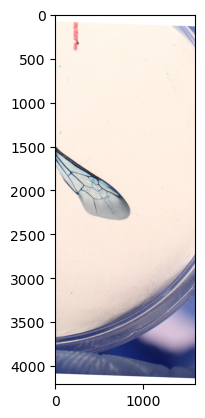

In [186]:
plt.imshow(card)